## Importing libraries, parameters.py

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = '/home/yoda/Aron/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=/home/yoda/Aron/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully c

In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse_logf (control parameters: ['p_A', 'logf', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


## Define ranges

In [3]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [50.0, 500.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [0.05]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [20.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [par.alfa_M],
    # vapour pressure [Pa] - will be calculated from T_inf
    P_v = [par.P_v],
    # dynamic viscosity [Pa*s] - will be calculated from T_inf
    mu_L = [0.0001, 0.053],
    # sound speed [m/s]
    c_L = [943.0, 1923.0],
    # surfactant (surface tension modfier) [-]
    surfactant = [0.0171/par.sigma, 0.075/par.sigma],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [-1e5*x for x in [1.5, 6.0]], # pressure amplitude [Pa]
    logf = [3.8, 5.0], # frequency [Hz]
    n = [1.0]
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

Starting the searches from random points is not a good practice. You may start them from the best points of a bruteforce search. Alternatively, you can use trial_points, and only use the best searches points as start points.

In [4]:
# create folder for parameter study results:
save_path = '/home/yoda/Aron/parameter_studies/Big_search/low_pressure2'
file = gd.de.Make_dir(save_path)
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 16    # number os total searches
trial_points = 10000  # number of trial start_points. best ones will be used for searches


kwargs_list = [
    dict(
        point=gd.rand_point(ranges, ID=i, padding=0.001),
        to_optimize=to_optimize,
        t_int=[0.0, 1.0],
        LSODA_timeout=30,
        Radau_timeout=300,
    )
for i in range(trial_points)]
best_energy_efficiency = 1e30
start_points = []

start = time.time()
file.new_file()
with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
    results = pool.imap_unordered(gd.evaluate_kwargs, kwargs_list)

    for result in results:
        data, point, success = result
        data = gd.de.dotdict(data)
        file.write_line(data)
        start_points.append(point)
      # print stuff:
        if data.energy_efficiency > 0 and data.energy_efficiency < best_energy_efficiency:
            best_energy_efficiency = data.energy_efficiency
        to_print = [f'{key}={data[key]: e};   ' for key in ranges if len(ranges[key]) == 2]
        to_print = ''.join(to_print)
        print(f'index: {data.ID: >8}/{len(kwargs_list)};   success: {success};   runtime: {data.elapsed_time: 6.2f} [s]   |   ' + to_print + '|   ' +
              f'{gd.de.target_specie} production: {data.energy_efficiency: e} [MJ/kg] (best: {best_energy_efficiency: .1f} [MJ/kg])'+
              '                                                 ', end='\r')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\nDONE')
print(f'total time: {elapsed: .2f} [s]   ({(elapsed / len(kwargs_list)): .2f} [s/run])')

Folder already exists with 0 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.64 [s]   |   R_E= 1.047164e-04;   mu_L= 3.412555e-02;   c_L= 1.157232e+03;   surfactant= 2.623128e-01;   p_A=-4.440266e+05;   logf= 4.874121e+00;   |   NH3 production:  1.884790e+26 [MJ/kg] (best:  148.0 [MJ/kg])                                                                             
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2263180849671D-03   r2 =  0.1186146222242D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2263180849671D-03   r2 =  0.1186146222242D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    5.65 [s]   |   R_E= 4.540699e-04;   mu_L= 1.482987e-02;   c_L= 1.783606e+03;   surfactant= 7.288129e-01;   p_A=-5.346775e+05;   logf= 4.524661e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  148.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1401403398079D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  6.91 [s]   |   R_E= 2.636111e-04;   mu_L= 1.367087e-02;   c_L= 1.393468e+03;   surfactant= 4.709023e-01;   p_A=-3.992492e+05;   logf= 4.458988e+00;   |   NH3 production:  8.682084e+22 [MJ/kg] (best:  148.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6270312683715D-04   r2 =  0.6099833072404D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6270312683715D-04   r2 =  0.6099833072404D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6270312683715D-04   r2 =  0.5054395142597D-20
 lsoda--  war

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1864298575234D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested     4.49 [s]   |   R_E= 7.315524e-05;   mu_L= 8.529816e-03;   c_L= 1.261811e+03;   surfactant= 3.978556e-01;   p_A=-5.656554e+05;   logf= 3.866161e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  133.3 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1617589135042D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.70 [s]   |   R_E= 3.547894e-04;   mu_L= 2.566110e-02;   c_L= 1.812821e+03;   surfactant= 5.171655e-01;   p_A=-4.374862e+05;   logf= 4.433065e+00;   |   NH3 production:  2.716398e+26 [MJ/kg] (best:  133.3 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7932249516588D-04   r2 =  0.5642720439618D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7932249516588D-04   r2 =  0.5642720439618D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7932249516588D-04   r2 =  0.5642720439618D-20
 lsoda--  war

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1353836952420D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1513237215786D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    9.62 [s]   |   R_E= 1.122037e-04;   mu_L= 5.769134e-03;   c_L= 1.663228e+03;   surfactant= 4.624151e-01;   p_A=-5.195646e+05;   logf= 4.267980e+00;   |   NH3 production:  1.177418e+03 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1249830260061D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested     5.11 [s]   |   R_E= 9.677841e-05;   mu_L= 1.388135e-02;   c_L= 1.008615e+03;   surfactant= 4.833401e-01;   p_A=-5.708392e+05;   logf= 3.965622e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2100677824552D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.78 [s]   |   R_E= 4.819723e-04;   mu_L= 4.430637e-02;   c_L= 1.103513e+03;   surfactant= 9.181255e-01;   p_A=-5.279884e+05;   logf= 4.707344e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1395400523256D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    0.79 [s]   |   R_E= 4.568339e-04;   mu_L= 4.258068e-02;   c_L= 1.525319e+03;   surfactant= 8.776570e-01;   p_A=-2.269071e+05;   logf= 4.566841e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  115.4 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2097482406693D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.89 [s]   |   R_E= 2.687408e-04;   mu_L= 3.988513e-02;   c_L=

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    8.34 [s]   |   R_E= 3.826801e-04;   mu_L= 1.361361e-02;   c_L= 1.691330e+03;   surfactant= 5.418887e-01;   p_A=-4.503310e+05;   logf= 4.047657e+00;   |   NH3 production:  4.835160e+02 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1333246356214D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    1.52 [s]   |   R_E= 3.955158e-04;   mu_L= 4.190316e-03;   c_L= 1.739120e+03;   surfactant= 8.045542e-01;   p_A=-4.371086e+05;   logf= 3.898263e+00;   |   NH3 production:  2.076683e+02 [MJ/kg] (best:  115.4 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1443154713011D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  4.19 [s]   |   R_E= 3.370921e-04;   mu_L= 2.107292e-02;   c_L=

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1164335811438D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    5.61 [s]   |   R_E= 3.941461e-04;   mu_L= 1.976246e-02;   c_L= 1.086379e+03;   surfactant= 2.456009e-01;   p_A=-5.838903e+05;   logf= 4.311164e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  115.4 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2056405397965D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    6.38 [s]   |   R_E= 3.796533e-04;   mu_L= 8.771887e-03;   c_L= 1.739843e+03;   surfactant= 6.237801e-01;   p_A=-3.794165e+05;   logf= 4.275313e+00;   |   NH3 production:  1.354354e+26 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1866447055980D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.76 [s]   |   R_E= 1.536284e-04;   mu_L= 9.672856e-03;   c_L= 1.748866e+03;   surfactant= 8.943709e-01;   p_A=-2.453855e+05;   logf= 4.684093e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1722870023048D-03   r2 =  0.1181145852086D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1722870023048D-03   r2 =  0.1181145852086D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1722870023048D-03   r2 =  0.9496069511511D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    8.52 [s]   |   R_E= 2.988732e-04;   mu_L= 2.436753e-03;   c_L= 1.421736e+03;   surfactant= 3.219019e-01;   p_A=-2.963231e+05;   logf= 4.325806e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2039220129998D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    2.32 [s]   |   R_E= 2.747996e-04;   mu_L= 4.437291e-02;   c_L= 1.045092e+03;   surfactant= 3.295005e-01;   p_A=-1.861763e+05;   logf= 3.934788e+00;   |   NH3 production:  5.898901e+04 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1624082369836D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.92 [s]   |   R_E= 1.668715e-04;   mu_L= 3.575476e-02;   c_L= 9.982576e+02;   surfactant= 3.551493e-01;   p_A=-3.043701e+05;   logf= 4.222655e+00;   |   NH3 production:  7.288751e+03 [MJ/kg] (best:  115.4 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1143742924879D-03   r2 =  0.5536042473691D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1143742924879D-03   r2 =  0.5536042473691D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1143742924879D-03   r2 =  0.4407363039387D-20
 lsoda--  war

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.48 [s]   |   R_E= 1.957128e-04;   mu_L= 3.261544e-02;   c_L= 1.384759e+03;   surfactant= 3.517560e-01;   p_A=-4.927531e+05;   logf= 4.277187e+00;   |   NH3 production:  2.783765e+02 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9191965229981D-04   r2 =  0.5721870516402D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9191965229981D-04   r2 =  0.5721870516402D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9191965229981D-04   r2 =  0.4611829231378D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.73 [s]   |   R_E= 1.906312e-04;   mu_L= 1.905170e-02;   c_L= 1.917922e+03;   surfactant= 8.453145e-01;   p_A=-1.941238e+05;   logf= 4.321821e+00;   |   NH3 production:  2.536682e+24 [MJ/kg] (best:  115.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1507946350559D-03   r2 =  0.1243846300155D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1507946350559D-03   r2 =  0.1243846300155D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1507946350559D-03   r2 =  0.1243846300155D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.17 [s]   |   R_E= 1.834418e-04;   mu_L= 2.226070e-02;   c_L= 1.287510e+03;   surfactant= 7.516023e-01;   p_A=-3.952708e+05;   logf= 4.688414e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  113.5 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2160800410055D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    0.52 [s]   |   R_E= 3.890404e-04;   mu_L= 3.786738e-03;   c_L= 1.317015e+03;   surfactant= 4.711680e-01;   p_A=-4.577175e+05;   logf= 3.899687e+00;   |   NH3 production:  2.766390e+02 [MJ/kg] (best:  113.5 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1791864804906D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8810669303929D-03   r2 =  0.4232581281019D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8810669303929D-03   r2 =  0.4232581281019D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8810669303929D-03   r2 =  0.4232581281019D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8810669303929D-03   r2 =  0.3163412396720D-19
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.50 [s]   |   R_E= 4.919996e-04;   mu_L= 3.196316e-02;   c_L= 1.149271e+03;   surfactant= 7.479617e-01;   p_A=-4.557064e+05;   logf= 4.589159e+00;   |   NH3 production:  2.895354e+24 [MJ/kg] (best:  113.5 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1099926017647D-03   r2 =  0.6181897410373D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1099926017647D-03   r2 =  0.6181897410373D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1099926017647D-03   r2 =  0.6181897410373D-20
 lsoda--  war

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.23 [s]   |   R_E= 1.127759e-04;   mu_L= 3.365825e-02;   c_L= 1.873460e+03;   surfactant= 1.025324e+00;   p_A=-1.620039e+05;   logf= 4.092123e+00;   |   NH3 production:  2.030181e+02 [MJ/kg] (best:  113.5 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1827266608583D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    1.60 [s]   |   R_E= 3.948391e-04;   mu_L= 1.999200e-02;   c_L= 1.687755e+03;   surfactant= 7.517438e-01;   p_A=-5.743787e+05;   logf= 4.542867e+00;   |   NH3 production:  5.769058e+24 [MJ/kg] (best:  113.5 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2017399612087D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.00 [s]   |   R_E= 4.405318e-04;   mu_L= 3.354654e-02;   c_L= 1.748294e+03;   surfactant= 7.566637e-01;   p_A=-2.523947e+05;   logf= 4.330362e+00;   |   NH3 production:  1.101825e+24 [MJ/kg] (best:  113.5 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2094662426671D-03   r2 =  0.1128559785631D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2094662426671D-03   r2 =  0.1128559785631D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2094662426671D-03   r2 =  0.1128559785631D-19
 lsoda--  war

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    1.03 [s]   |   R_E= 7.403103e-05;   mu_L= 4.927759e-02;   c_L= 9.955725e+02;   surfactant= 9.740657e-01;   p_A=-1.521573e+05;   logf= 4.236336e+00;   |   NH3 production:  9.719053e+03 [MJ/kg] (best:  113.5 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1449829278396D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.58 [s]   |   R_E= 2.623020e-04;   mu_L= 4.314055e-02;   c_L= 1.806689e+03;   surfactant= 2.661453e-01;   p_A=-4.792216e+05;   logf= 4.151221e+00;   |   NH3 production:  1.593878e+02 [MJ/kg] (best:  113.5 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1605399287742D-03   r2 =  0.1113722103088D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  35.50 [s]   |   R_E= 2.042634e-04;   mu_L= 2.062285e-03;   c_L= 1.617296e+03;   surfactant= 6.626025e-01;   p_A=-4.986773e+05;   logf= 3.848193e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  113.5 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1320138497393D-03   r2 =  0.1127376394511D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1320138497393D-03   r2 =  0.1127376394511D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1320138497393D-03   r2 =  0.8944035787968D-20
 lsoda--  war

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.60 [s]   |   R_E= 1.496526e-04;   mu_L= 1.525710e-02;   c_L= 1.345904e+03;   surfactant= 7.326701e-01;   p_A=-3.009499e+05;   logf= 4.101551e+00;   |   NH3 production:  3.709811e+02 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1366484382993D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.11 [s]   |   R_E= 3.221716e-04;   mu_L= 4.290513e-02;   c_L= 1.463784e+03;   surfactant= 7.718440e-01;   p_A=-5.538864e+05;   logf= 4.085345e+00;   |   NH3 production:  2.004613e+02 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1336505124276D-03   r2 =  0.1168226716695D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.80 [s]   |   R_E= 4.727986e-04;   mu_L= 3.496552e-02;   c_L= 1.309913e+03;   surfactant= 6.009618e-01;   p_A=-2.128288e+05;   logf= 3.812894e+00;   |   NH3 production:  8.584816e+05 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8212234526568D-03   r2 =  0.4923410686612D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8212234526568D-03   r2 =  0.4923410686612D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8212234526568D-03   r2 =  0.4923410686612D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.11 [s]   |   R_E= 1.274342e-04;   mu_L= 2.250586e-02;   c_L= 1.783652e+03;   surfactant= 6.435279e-01;   p_A=-4.402074e+05;   logf= 4.729737e+00;   |   NH3 production:  9.624221e+26 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1026637499688D-03   r2 =  0.6122361335868D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1026637499688D-03   r2 =  0.6122361335868D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1026637499688D-03   r2 =  0.4887957755720D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.79 [s]   |   R_E= 2.224964e-04;   mu_L= 4.345950e-02;   c_L= 1.737704e+03;   surfactant= 6.285433e-01;   p_A=-5.077777e+05;   logf= 4.592169e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3708564366584D+00   r2 =  0.2444018869387D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3708564366584D+00   r2 =  0.2444018869387D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3708564366584D+00   r2 =  0.2444018869387D-16
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.47 [s]   |   R_E= 1.114034e-04;   mu_L= 4.529371e-02;   c_L= 1.198541e+03;   surfactant= 3.351542e-01;   p_A=-2.033944e+05;   logf= 4.226138e+00;   |   NH3 production:  3.590538e+03 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1295057641411D-03   r2 =  0.1089484603494D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1295057641411D-03   r2 =  0.1089484603494D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1295057641411D-03   r2 =  0.8338807948590D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1798697354048D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.89 [s]   |   R_E= 4.795004e-04;   mu_L= 3.401987e-02;   c_L= 1.322017e+03;   surfactant= 6.431334e-01;   p_A=-2.501260e+05;   logf= 4.553896e+00;   |   NH3 production:  3.437327e+23 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2138248583371D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.71 [s]   |   R_E= 2.989707e-04;   mu_L= 4.244569e-03;   c_L= 1.764713e+03;   surfactant= 5.702895e-01;   p_A=-2.417742e+05;   logf= 4.028003e+00;   |   NH3 production:  3.592672e+04 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2230836108041D-03   r2 =  0.1276952389913D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.65 [s]   |   R_E= 2.437935e-04;   mu_L= 2.925081e-02;   c_L= 1.175374e+03;   surfactant= 7.383167e-01;   p_A=-4.301356e+05;   logf= 4.290177e+00;   |   NH3 production:  3.671193e+06 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1627074900766D-03   r2 =  0.1061907593187D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1627074900766D-03   r2 =  0.1061907593187D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1627074900766D-03   r2 =  0.8803738233773D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1015758503693D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1780272947566D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2103954777536D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.73 [s]   |   R_E= 7.882339e-05;   mu_L= 1.072127e-02;   c_L= 1.876716e+03;   surfactant= 3.446722e-01;   p_A=-5.414979e+05;   logf= 4.558405e+00;   |   NH3 production:  3.021763e+02 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320962426535D-03   r2 =  0.1181756353984D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2320962426535D-03   r2 =  0.1181756353984D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.19 [s]   |   R_E= 1.311636e-04;   mu_L= 1.153183e-02;   c_L= 1.765843e+03;   surfactant= 6.614869e-01;   p_A=-3.507346e+05;   logf= 4.908230e+00;   |   NH3 production:  1.349666e+24 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1916750018600D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.42 [s]   |   R_E= 1.462978e-04;   mu_L= 2.698315e-02;   c_L= 1.195028e+03;   surfactant= 8.391147e-01;   p_A=-4.860447e+05;   logf= 4.422490e+00;   |   NH3 production:  3.847468e+03 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2793742682821D-03   r2 =  0.2233158156437D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.72 [s]   |   R_E= 3.483239e-04;   mu_L= 1.588695e-02;   c_L= 1.408839e+03;   surfactant= 6.924964e-01;   p_A=-3.167885e+05;   logf= 4.890988e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2049738342961D-03   r2 =  0.1193559111000D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2049738342961D-03   r2 =  0.1193559111000D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2049738342961D-03   r2 =  0.9456135660430D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1111881312494D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.77 [s]   |   R_E= 1.218645e-04;   mu_L= 2.331399e-02;   c_L= 1.465334e+03;   surfactant= 1.030113e+00;   p_A=-5.907651e+05;   logf= 4.337399e+00;   |   NH3 production:  6.608077e+02 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1125401992286D-03   r2 =  0.5515441871704D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1125401992286D-03   r2 =  0.5515441871704D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1125401992286D-03   r2 =  0.4230185747290D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.06 [s]   |   R_E= 1.853535e-04;   mu_L= 2.438341e-02;   c_L= 1.097176e+03;   surfactant= 4.690241e-01;   p_A=-3.829872e+05;   logf= 4.636432e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1466658066310D-03   r2 =  0.1297084903795D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1466658066310D-03   r2 =  0.1297084903795D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1466658066310D-03   r2 =  0.1297084903795D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    0.50 [s]   |   R_E= 9.273325e-05;   mu_L= 3.897990e-02;   c_L= 1.280321e+03;   surfactant= 4.207202e-01;   p_A=-5.945668e+05;   logf= 4.983420e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1827044621134D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    3.95 [s]   |   R_E= 1.944391e-04;   mu_L= 1.845750e-02;   c_L= 1.416665e+03;   surfactant= 9.900919e-01;   p_A=-5.022816e+05;   logf= 4.034826e+00;   |   NH3 production:  1.428517e+03 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2090029297785D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  6.48 [s]   |   R_E= 2.316439e-04;   mu_L= 1.195398e-02;   c_L= 1.540229e+03;   surfactant= 7.634364e-01;   p_A=-3.812287e+05;   logf= 4.912759e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8530148477333D-04   r2 =  0.6647352424871D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.35 [s]   |   R_E= 2.738390e-04;   mu_L= 7.771508e-03;   c_L= 1.261921e+03;   surfactant= 9.075601e-01;   p_A=-1.597189e+05;   logf= 4.423603e+00;   |   NH3 production:  2.907431e+25 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1885610436494D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.90 [s]   |   R_E= 8.389701e-05;   mu_L= 3.648020e-02;   c_L= 1.524592e+03;   surfactant= 6.320123e-01;   p_A=-3.212404e+05;   logf= 4.222278e+00;   |   NH3 production:  1.321054e+03 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3451489927683D-03   r2 =  0.2351125142830D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.23 [s]   |   R_E= 1.806546e-04;   mu_L= 5.196785e-03;   c_L= 1.816571e+03;   surfactant= 7.946174e-01;   p_A=-5.643116e+05;   logf= 4.732070e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2166519428817D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    6.96 [s]   |   R_E= 4.392943e-04;   mu_L= 8.115600e-03;   c_L= 1.331409e+03;   surfactant= 3.623432e-01;   p_A=-3.163673e+05;   logf= 3.842194e+00;   |   NH3 production:  1.564591e+02 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1299765042877D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    4.78 [s]   |   R_E= 3.854657e-04;   mu_L= 7.830266e-03;   c_L= 1.072683e+03;   surfactant= 9.194909e-01;   p_A=-2.941752e+05;   logf= 4.801571e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1068439537107D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1488175483989D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.33 [s]   |   R_E= 4.796826e-04;   mu_L= 3.359251e-02;   c_L= 1.211072e+03;   surfactant= 2.420224e-01;   p_A=-4.075656e+05;   logf= 4.860903e+00;   |   NH3 production:  1.043488e+24 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2074416162504D-03   r2 =  0.1343889101753D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2074416162504D-03   r2 =  0.1343889101753D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2074416162504D-03   r2 =  0.1089571100077D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1988590459180D-03   r2 =  0.1353456068190D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1988590459180D-03   r2 =  0.1353456068190D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1988590459180D-03   r2 =  0.1074094790353D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1988590459180D-03   r2 =  0.1074094790353D-19
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.62 [s]   |   R_E= 9.349036e-05;   mu_L= 4.007658e-02;   c_L= 1.410282e+03;   surfactant= 9.173676e-01;   p_A=-2.897056e+05;   logf= 4.229444e+00;   |   NH3 production:  6.074324e+02 [MJ/kg] (best:  97.3 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1048806813413D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.67 [s]   |   R_E= 3.297590e-04;   mu_L= 4.785940e-02;   c_L= 1.189654e+03;   surfactant= 7.744431e-01;   p_A=-5.072074e+05;   logf= 4.617714e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1429120157348D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.53 [s]   |   R_E= 3.451409e-04;   mu_L= 4.172058e-02;   c_L= 1.916352e+03;   surfactant= 4.256403e-01;   p_A=-4.595731e+05;   logf= 4.066299e+00;   |   NH3 production:  1.787432e+02 [MJ/kg] (best:  97.3 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6392222371130D-04   r2 =  0.5868817955570D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6392222371130D-04   r2 =  0.5868817955570D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6392222371130D-04   r2 =  0.4716844980259D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.92 [s]   |   R_E= 4.264869e-04;   mu_L= 4.210046e-02;   c_L= 1.880078e+03;   surfactant= 8.176676e-01;   p_A=-2.889794e+05;   logf= 4.464218e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1319719757295D-03   r2 =  0.1342605352363D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1319719757295D-03   r2 =  0.1342605352363D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1319719757295D-03   r2 =  0.1002174460611D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1753439352554D+00   r2 =  0.2446773914594D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.82 [s]   |   R_E= 3.718761e-04;   mu_L= 3.293747e-02;   c_L= 1.397265e+03;   surfactant= 2.429631e-01;   p_A=-3.584042e+05;   logf= 4.961921e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1784426460489D-03   r2 =  0.1267422577910D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1784426460489D-03   r2 =  0.1267422577910D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1784426460489D-03   r2 =  0.1267422577910D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1811717984208D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    0.77 [s]   |   R_E= 3.156618e-04;   mu_L= 3.175528e-02;   c_L= 9.636574e+02;   surfactant= 5.868827e-01;   p_A=-3.016053e+05;   logf= 4.915875e+00;   |   NH3 production:  2.693643e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1529073655601D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    2.28 [s]   |   R_E= 2.798444e-04;   mu_L= 6.124528e-03;   c_L= 1.276070e+03;   surfactant= 4.837271e-01;   p_A=-3.743887e+05;   logf= 3.897384e+00;   |   NH3 production:  5.517908e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1720619494068D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1940610892233D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.65 [s]   |   R_E= 3.981919e-04;   mu_L= 1.117233e-02;   c_L= 1.581418e+03;   surfactant= 7.410813e-01;   p_A=-2.616408e+05;   logf= 4.784390e+00;   |   NH3 production:  1.314387e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1107908882525D-03   r2 =  0.5709198571160D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1107908882525D-03   r2 =  0.5709198571160D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1107908882525D-03   r2 =  0.4585095178613D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1344089025469D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.45 [s]   |   R_E= 1.137957e-04;   mu_L= 1.476753e-02;   c_L= 1.787540e+03;   surfactant= 7.020734e-01;   p_A=-5.283879e+05;   logf= 4.726791e+00;   |   NH3 production:  1.182866e+12 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1379941754283D-03   r2 =  0.1206534499426D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1379941754283D-03   r2 =  0.1206534499426D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.81 [s]   |   R_E= 4.102444e-04;   mu_L= 3.695358e-02;   c_L= 1.734248e+03;   surfactant= 7.290345e-01;   p_A=-4.536425e+05;   logf= 4.196233e+00;   |   NH3 production:  1.385542e+17 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1367144042325D-03   r2 =  0.1229219876056D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1367144042325D-03   r2 =  0.1229219876056D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1367144042325D-03   r2 =  0.9987389387882D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.62 [s]   |   R_E= 1.291292e-04;   mu_L= 4.865027e-02;   c_L= 1.707659e+03;   surfactant= 6.859962e-01;   p_A=-2.971205e+05;   logf= 4.601410e+00;   |   NH3 production:  3.736675e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2200545057970D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.80 [s]   |   R_E= 3.827126e-04;   mu_L= 2.347665e-02;   c_L= 1.646706e+03;   surfactant= 1.001487e+00;   p_A=-4.399614e+05;   logf= 4.969771e+00;   |   NH3 production:  1.352203e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2359323054005D-03   r2 =  0.1340709408390D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2359323054005D-03   r2 =  0.1340709408390D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2359323054005D-03   r2 =  0.1037560382847D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1456681674649D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  7.12 [s]   |   R_E= 3.195248e-04;   mu_L= 2.744694e-04;   c_L= 1.567048e+03;   surfactant= 4.568883e-01;   p_A=-5.475252e+05;   logf= 4.747782e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9821625936808D-04   r2 =  0.6367491998571D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9821625936808D-04   r2 =  0.6367491998571D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9821625936808D-04   r2 =  0.6367491998571D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.17 [s]   |   R_E= 4.576933e-04;   mu_L= 3.663458e-02;   c_L= 1.767770e+03;   surfactant= 9.661916e-01;   p_A=-4.566556e+05;   logf= 4.887638e+00;   |   NH3 production:  5.796219e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1977283948441D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested     4.93 [s]   |   R_E= 1.130037e-04;   mu_L= 3.269538e-02;   c_L= 1.221073e+03;   surfactant= 4.783789e-01;   p_A=-5.596898e+05;   logf= 3.937121e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1922567232981D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested     5.02 [s]   |   R_E= 1.418809e-04;   mu_L= 4.192310e-02;   c_L=

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.53 [s]   |   R_E= 3.346275e-04;   mu_L= 4.358528e-02;   c_L= 1.369657e+03;   surfactant= 5.022144e-01;   p_A=-1.590455e+05;   logf= 4.780012e+00;   |   NH3 production:  1.802507e+22 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1287646027469D-03   r2 =  0.1176181022024D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1287646027469D-03   r2 =  0.1176181022024D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1287646027469D-03   r2 =  0.9779886924280D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1130720917969D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.74 [s]   |   R_E= 4.376300e-04;   mu_L= 3.589994e-02;   c_L= 9.725324e+02;   surfactant= 6.240493e-01;   p_A=-2.635158e+05;   logf= 4.537712e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1969308858518D-03   r2 =  0.1080522191433D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1969308858518D-03   r2 =  0.1080522191433D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1710047364823D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    0.75 [s]   |   R_E= 3.170412e-04;   mu_L= 3.341729e-02;   c_L= 1.334596e+03;   surfactant= 1.013078e+00;   p_A=-3.250601e+05;   logf= 4.877296e+00;   |   NH3 production:  1.898057e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1184839354537D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.46 [s]   |   R_E= 2.767780e-04;   mu_L= 2.529352e-02;   c_L= 1.192386e+03;   surfactant= 3.146725e-01;   p_A=-5.947406e+05;   logf= 3.890464e+00;   |   NH3 production:  3.414824e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1036673125931D-03   r2 =  0.5747651582574D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1036673125931D-03   r2 =  0.5747651582574D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1036673125931D-03   r2 =  0.5747651582574D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.47 [s]   |   R_E= 3.113163e-04;   mu_L= 2.457954e-02;   c_L= 1.295650e+03;   surfactant= 5.640485e-01;   p_A=-3.719102e+05;   logf= 4.766042e+00;   |   NH3 production:  2.807050e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2196321235966D-03   r2 =  0.1068937504415D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2196321235966D-03   r2 =  0.1068937504415D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2196321235966D-03   r2 =  0.8190776942160D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.92 [s]   |   R_E= 6.730063e-05;   mu_L= 4.811213e-02;   c_L= 1.550906e+03;   surfactant= 6.607460e-01;   p_A=-2.696151e+05;   logf= 4.660931e+00;   |   NH3 production:  2.092617e+13 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1541820427419D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.36 [s]   |   R_E= 1.404299e-04;   mu_L= 3.985367e-03;   c_L= 9.924643e+02;   surfactant= 9.958516e-01;   p_A=-3.555553e+05;   logf= 4.904473e+00;   |   NH3 production:  1.396357e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1353310772359D-03   r2 =  0.1249519084427D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.48 [s]   |   R_E= 8.751138e-05;   mu_L= 4.452834e-02;   c_L= 1.068995e+03;   surfactant= 3.351773e-01;   p_A=-4.820037e+05;   logf= 4.379631e+00;   |   NH3 production:  1.082157e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1436947320525D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    0.91 [s]   |   R_E= 3.393337e-04;   mu_L= 4.305507e-02;   c_L= 1.609566e+03;   surfactant= 5.974500e-01;   p_A=-1.932943e+05;   logf= 4.693407e+00;   |   NH3 production:  2.766164e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1823348179380D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1589395833246D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  4.09 [s]   |   R_E= 2.507562e-04;   mu_L= 2.291910e-02;   c_L= 1.114900e+03;   surfactant= 2.475861e-01;   p_A=-5.834273e+05;   logf= 3.981495e+00;   |   NH3 production:  1.833060e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9907161687214D-04   r2 =  0.6715734081090D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9907161687214D-04   r2 =  0.6715734081090D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.57 [s]   |   R_E= 4.070949e-04;   mu_L= 2.669759e-02;   c_L= 1.539728e+03;   surfactant= 6.872932e-01;   p_A=-2.959066e+05;   logf= 4.897428e+00;   |   NH3 production:  2.788762e+22 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1570410390883D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  7.93 [s]   |   R_E= 3.158735e-04;   mu_L= 7.054687e-03;   c_L= 1.828900e+03;   surfactant= 6.795673e-01;   p_A=-2.462207e+05;   logf= 4.242690e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1874755398555D-03   r2 =  0.1123826411918D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.06 [s]   |   R_E= 4.278928e-04;   mu_L= 4.157365e-02;   c_L= 1.848548e+03;   surfactant= 9.416714e-01;   p_A=-1.942883e+05;   logf= 4.144345e+00;   |   NH3 production:  5.080655e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2226745093219D-03   r2 =  0.1141332504075D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2226745093219D-03   r2 =  0.1141332504075D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2226745093219D-03   r2 =  0.9473498985930D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.86 [s]   |   R_E= 1.853123e-04;   mu_L= 1.499253e-02;   c_L= 1.255549e+03;   surfactant= 5.826582e-01;   p_A=-2.611304e+05;   logf= 4.460221e+00;   |   NH3 production:  8.036904e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1355463494699D-03   r2 =  0.1305531694068D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1355463494699D-03   r2 =  0.1305531694068D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1355463494699D-03   r2 =  0.1305531694068D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.70 [s]   |   R_E= 4.927330e-04;   mu_L= 2.352374e-02;   c_L= 1.470320e+03;   surfactant= 9.369482e-01;   p_A=-1.887811e+05;   logf= 4.994747e+00;   |   NH3 production:  1.104760e+22 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9895017736561D-03   r2 =  0.8958641677489D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9895017736561D-03   r2 =  0.8958641677489D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9895017736561D-03   r2 =  0.8958641677489D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.26 [s]   |   R_E= 3.860720e-04;   mu_L= 3.899395e-02;   c_L= 9.468026e+02;   surfactant= 9.155075e-01;   p_A=-4.039171e+05;   logf= 3.866079e+00;   |   NH3 production:  3.342234e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5224911730023D+00   r2 =  0.4801398045550D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5224911730023D+00   r2 =  0.4801398045550D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5224911730023D+00   r2 =  0.4801398045550D-16
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.76 [s]   |   R_E= 4.287713e-04;   mu_L= 5.084557e-02;   c_L= 1.681191e+03;   surfactant= 9.540028e-01;   p_A=-3.689876e+05;   logf= 4.590368e+00;   |   NH3 production:  1.558800e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1931471538954D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.83 [s]   |   R_E= 3.271420e-04;   mu_L= 5.114715e-02;   c_L= 1.171768e+03;   surfactant= 8.441620e-01;   p_A=-5.011277e+05;   logf= 4.617790e+00;   |   NH3 production:  2.944476e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1349302282604D-03   r2 =  0.1289537431351D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.65 [s]   |   R_E= 7.660438e-05;   mu_L= 4.406389e-02;   c_L= 1.250322e+03;   surfactant= 5.793995e-01;   p_A=-5.126449e+05;   logf= 4.346245e+00;   |   NH3 production:  2.503329e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782689590034D-03   r2 =  0.1227153848983D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782689590034D-03   r2 =  0.1227153848983D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782689590034D-03   r2 =  0.1017818479327D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2065519107598D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1500072299137D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.58 [s]   |   R_E= 1.898407e-04;   mu_L= 2.662235e-02;   c_L= 9.580735e+02;   surfactant= 7.597994e-01;   p_A=-1.609808e+05;   logf= 4.214695e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1191632828402D-03   r2 =  0.5400058776994D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1191632828402D-03   r2 =  0.5400058776994D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1191632828402D-03   r2 =  0.5400058776994D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.27 [s]   |   R_E= 3.968781e-04;   mu_L= 2.100293e-02;   c_L= 1.851629e+03;   surfactant= 2.692862e-01;   p_A=-5.620358e+05;   logf= 4.369063e+00;   |   NH3 production:  1.876597e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2160023936491D-03   r2 =  0.1166460160031D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2160023936491D-03   r2 =  0.1166460160031D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2160023936491D-03   r2 =  0.1166460160031D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  9.00 [s]   |   R_E= 1.330097e-04;   mu_L= 3.770576e-03;   c_L= 1.413637e+03;   surfactant= 5.186796e-01;   p_A=-3.625718e+05;   logf= 3.958987e+00;   |   NH3 production:  4.164875e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4554563673549D-04   r2 =  0.3150726146213D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4554563673549D-04   r2 =  0.3150726146213D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4554563673549D-04   r2 =  0.3150726146213D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1610540835077D+00   r2 =  0.1154160462376D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1610540835077D+00   r2 =  0.1154160462376D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1610540835077D+00   r2 =  0.1154160462376D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1610540835077D+00   r2 =  0.9580768409475D-17
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1256888975503D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.88 [s]   |   R_E= 3.735083e-04;   mu_L= 2.230510e-02;   c_L= 1.510105e+03;   surfactant= 1.008168e+00;   p_A=-3.549343e+05;   logf= 4.122148e+00;   |   NH3 production:  1.971781e+11 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2257483738183D-03   r2 =  0.1234191065933D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2257483738183D-03   r2 =  0.1234191065933D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2257483738183D-03   r2 =  0.1019360876781D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1910084792223D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  9.18 [s]   |   R_E= 4.309206e-04;   mu_L= 4.635201e-02;   c_L= 1.556991e+03;   surfactant= 4.416896e-01;   p_A=-2.776590e+05;   logf= 4.093504e+00;   |   NH3 production:  6.869840e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1569447375652D-03   r2 =  0.1110751608946D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1569447375652D-03   r2 =  0.1110751608946D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.09 [s]   |   R_E= 3.664908e-04;   mu_L= 1.033604e-02;   c_L= 1.223976e+03;   surfactant= 8.156881e-01;   p_A=-2.966513e+05;   logf= 4.285693e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9633388791812D-04   r2 =  0.6204692399834D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9633388791812D-04   r2 =  0.6204692399834D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9633388791812D-04   r2 =  0.5057771166155D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.83 [s]   |   R_E= 2.771278e-04;   mu_L= 7.604430e-03;   c_L= 1.752573e+03;   surfactant= 6.608905e-01;   p_A=-2.555948e+05;   logf= 4.111159e+00;   |   NH3 production:  2.193231e+06 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1827212709798D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.14 [s]   |   R_E= 4.924715e-04;   mu_L= 2.168278e-02;   c_L= 1.762350e+03;   surfactant= 5.694287e-01;   p_A=-3.145679e+05;   logf= 4.589804e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2264218636230D-03   r2 =  0.1276389949196D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.09 [s]   |   R_E= 4.013513e-04;   mu_L= 8.673018e-03;   c_L= 1.758753e+03;   surfactant= 6.026372e-01;   p_A=-5.134384e+05;   logf= 4.617600e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5154301273627D-04   r2 =  0.2765417672166D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5154301273627D-04   r2 =  0.2765417672166D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5154301273627D-04   r2 =  0.2169007199334D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    7.82 [s]   |   R_E= 3.302781e-04;   mu_L= 1.673875e-02;   c_L= 1.588112e+03;   surfactant= 8.308714e-01;   p_A=-3.706790e+05;   logf= 3.933196e+00;   |   NH3 production:  1.892408e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1558075400950D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.77 [s]   |   R_E= 1.030703e-04;   mu_L= 1.356637e-03;   c_L= 1.507533e+03;   surfactant= 5.040120e-01;   p_A=-2.850730e+05;   logf= 4.368935e+00;   |   NH3 production:  2.303645e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2159367647781D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1595684443976D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.75 [s]   |   R_E= 1.770362e-04;   mu_L= 1.279614e-03;   c_L= 1.278911e+03;   surfactant= 8.741489e-01;   p_A=-5.500278e+05;   logf= 4.774212e+00;   |   NH3 production:  8.410130e+22 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1045818748281D-03   r2 =  0.6178574159935D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1045818748281D-03   r2 =  0.6178574159935D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1911839015948D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.08 [s]   |   R_E= 2.233083e-04;   mu_L= 3.800663e-02;   c_L= 1.251239e+03;   surfactant= 9.357519e-01;   p_A=-2.953428e+05;   logf= 4.349148e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100038186953D-03   r2 =  0.6537308252178D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100038186953D-03   r2 =  0.6537308252178D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100038186953D-03   r2 =  0.5315334944548D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    9.17 [s]   |   R_E= 2.557125e-04;   mu_L= 7.026178e-03;   c_L= 1.733237e+03;   surfactant= 9.226809e-01;   p_A=-5.309260e+05;   logf= 3.951605e+00;   |   NH3 production:  1.374441e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1837140855052D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1865603297468D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.07 [s]   |   R_E= 4.544667e-04;   mu_L= 4.580508e-02;   c_L= 1.308455e+03;   surfactant= 1.009193e+00;   p_A=-4.873069e+05;   logf= 4.484474e+00;   |   NH3 production:  1.459428e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3288475408061D-03   r2 =  0.2632419614836D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3288475408061D-03   r2 =  0.2632419614836D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested     4.74 [s]   |   R_E= 1.148072e-04;   mu_L= 4.577002e-02;   c_L= 1.511352e+03;   surfactant= 9.259579e-01;   p_A=-4.615349e+05;   logf= 3.868757e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1755036043154D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1909775008180D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.55 [s]   |   R_E= 4.597084e-04;   mu_L= 8.672220e-03;   c_L= 1.853758e+03;   surfactant= 7.911381e-01;   p_A=-5.654489e+05;   logf= 4.627808e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1225877743761D-03   r2 =  0.1334525052598D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1225877743761D-03   r2 =  0.1334525052598D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1225877743761D-03   r2 =  0.1334525052598D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    0.96 [s]   |   R_E= 4.280966e-04;   mu_L= 3.542078e-02;   c_L= 1.005655e+03;   surfactant= 6.133334e-01;   p_A=-5.260570e+05;   logf= 4.548423e+00;   |   NH3 production:  7.947144e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1974332388217D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    0.45 [s]   |   R_E= 4.834832e-04;   mu_L= 2.889622e-03;   c_L= 1.411299e+03;   surfactant= 4.722543e-01;   p_A=-3.591698e+05;   logf= 3.820461e+00;   |   NH3 production:  1.242945e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1307376031265D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.79 [s]   |   R_E= 1.916257e-04;   mu_L= 2.091324e-02;   c_L= 1.307220e+03;   surfactant= 5.142848e-01;   p_A=-4.048126e+05;   logf= 4.902909e+00;   |   NH3 production:  5.113924e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1126048186776D-03   r2 =  0.5491804926994D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1126048186776D-03   r2 =  0.5491804926994D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1126048186776D-03   r2 =  0.5491804926994D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1085512092466D+00   r2 =  0.5545606843964D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  6.94 [s]   |   R_E= 1.742036e-04;   mu_L= 1.016885e-02;   c_L= 1.053070e+03;   surfactant= 9.856612e-01;   p_A=-4.481861e+05;   logf= 4.179532e+00;   |   NH3 production:  3.291404e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1161406708960D-03   r2 =  0.5748898488225D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1161406708960D-03   r2 =  0.5748898488225D-20
 lsoda--  warning..internal t (=r1) and h (

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2159502574152D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.98 [s]   |   R_E= 4.599060e-04;   mu_L= 3.013297e-02;   c_L= 1.267582e+03;   surfactant= 2.595648e-01;   p_A=-4.736003e+05;   logf= 4.885507e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2062766232060D+00   r2 =  0.1378606994698D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2062766232060D+00   r2 =  0.1378606994698D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2062766232060D+00   r2 =  0.1378606994698D-16
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2062672101205D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    1.94 [s]   |   R_E= 4.471629e-04;   mu_L= 5.039071e-02;   c_L= 9.773187e+02;   surfactant= 3.146278e-01;   p_A=-4.757584e+05;   logf= 4.160867e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2151890483427D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1447705837067D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    2.13 [s]   |   R_E= 2.742230e-04;   mu_L= 9.693431e-03;   c_L= 1.628437e+03;   surfactant= 4.588602e-01;   p_A=-1.567089e+05;   logf= 4.955704e+00;   |   NH3 production:  2.698269e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1267465754664D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    8.24 [s]   |   R_E= 2.485317e-04;   mu_L= 6.289377e-03;   c_L= 1.630431e+03;   surfactant= 7.548156e-01;   p_A=-2.503697e+05;   logf= 4.446466e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1447034133483D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.90 [s]   |   R_E= 2.011961e-04;   mu_L= 2.936064e-02;   c_L= 1.592653e+03;   surfactant= 5.605243e-01;   p_A=-5.136293e+05;   logf= 3.906425e+00;   |   NH3 production:  5.338122e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1135270673731D-03   r2 =  0.5725609139359D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1135270673731D-03   r2 =  0.5725609139359D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1135270673731D-03   r2 =  0.4582322816644D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.84 [s]   |   R_E= 4.584381e-04;   mu_L= 4.258936e-02;   c_L= 1.459188e+03;   surfactant= 7.835615e-01;   p_A=-5.112188e+05;   logf= 4.760191e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1623496373821D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  4.11 [s]   |   R_E= 2.787430e-04;   mu_L= 2.333950e-02;   c_L= 1.619809e+03;   surfactant= 1.025620e+00;   p_A=-3.729038e+05;   logf= 3.820471e+00;   |   NH3 production:  1.230946e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1175731596377D-03   r2 =  0.5511752066315D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    6.81 [s]   |   R_E= 3.720892e-04;   mu_L= 2.073305e-02;   c_L= 1.474409e+03;   surfactant= 1.007687e+00;   p_A=-4.005303e+05;   logf= 3.879080e+00;   |   NH3 production:  2.737351e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1752936807332D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    2.41 [s]   |   R_E= 1.508240e-04;   mu_L= 3.173232e-02;   c_L= 1.215426e+03;   surfactant= 6.560740e-01;   p_A=-5.707301e+05;   logf= 4.147115e+00;   |   NH3 production:  2.024627e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6480546535910D-04   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.00 [s]   |   R_E= 3.225074e-04;   mu_L= 2.804196e-02;   c_L= 1.109858e+03;   surfactant= 5.452638e-01;   p_A=-2.188530e+05;   logf= 4.861665e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2192175221018D-03   r2 =  0.1193414890032D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2192175221018D-03   r2 =  0.1193414890032D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2192175221018D-03   r2 =  0.8988956584727D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.84 [s]   |   R_E= 4.834375e-04;   mu_L= 3.489660e-02;   c_L= 1.152351e+03;   surfactant= 6.288718e-01;   p_A=-5.922614e+05;   logf= 4.871157e+00;   |   NH3 production:  1.653157e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1479783995601D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    5.38 [s]   |   R_E= 3.230287e-04;   mu_L= 1.163401e-02;   c_L= 1.074768e+03;   surfactant= 8.033737e-01;   p_A=-2.440429e+05;   logf= 4.550073e+00;   |   NH3 production:  1.059835e+40 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2076887218890D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.02 [s]   |   R_E= 1.392776e-04;   mu_L= 2.196187e-02;   c_L= 1.683676e+03;   surfactant= 1.003196e+00;   p_A=-5.033819e+05;   logf= 4.786502e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1998136217982D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  7.44 [s]   |   R_E= 1.327134e-04;   mu_L= 4.855368e-03;   c_L= 1.017834e+03;   surfactant= 7.740866e-01;   p_A=-5.842053e+05;   logf= 4.645802e+00;   |   NH3 production:  5.528874e+07 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1640763177954D-03   r2 =  0.1262482619397D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1556125656300D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1544998043891D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1693499275209D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.36 [s]   |   R_E= 7.518006e-05;   mu_L= 3.515244e-02;   c_L= 1.517653e+03;   surfactant= 3.432190e-01;   p_A=-5.475519e+05;   logf= 4.638618e+00;   |   NH3 production:  4.447492e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6585523373660D-04   r2 =  0.6247539526577D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6585523373660D-04   r2 =  0.6247539526577D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.69 [s]   |   R_E= 4.663225e-04;   mu_L= 4.848948e-02;   c_L= 1.106848e+03;   surfactant= 8.861239e-01;   p_A=-1.715400e+05;   logf= 4.505646e+00;   |   NH3 production:  5.787334e+22 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1425449634317D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.79 [s]   |   R_E= 4.235369e-04;   mu_L= 1.649418e-02;   c_L= 1.099070e+03;   surfactant= 5.337660e-01;   p_A=-3.314262e+05;   logf= 4.466484e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7604619826168D-04   r2 =  0.6108016870408D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.73 [s]   |   R_E= 4.175405e-04;   mu_L= 3.896812e-02;   c_L= 1.309392e+03;   surfactant= 6.944663e-01;   p_A=-3.525087e+05;   logf= 4.968910e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1416950641971D-03   r2 =  0.1037698903299D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1416950641971D-03   r2 =  0.1037698903299D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1416950641971D-03   r2 =  0.8591719530877D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.55 [s]   |   R_E= 4.760516e-04;   mu_L= 2.584980e-02;   c_L= 1.476268e+03;   surfactant= 5.886817e-01;   p_A=-5.572136e+05;   logf= 4.519861e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1980939211960D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.51 [s]   |   R_E= 3.719295e-04;   mu_L= 5.252479e-02;   c_L= 1.791351e+03;   surfactant= 6.799534e-01;   p_A=-6.002464e+05;   logf= 3.982896e+00;   |   NH3 production:  4.162484e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1528594201831D-02   r2 =  0.9351934289144D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1528594201831D-02   r2 =  0.9351934289144D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1528594201831D-02   r2 =  0.7541337015957D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    4.77 [s]   |   R_E= 6.693892e-05;   mu_L= 5.864032e-03;   c_L= 1.326749e+03;   surfactant= 3.302881e-01;   p_A=-2.109182e+05;   logf= 4.118749e+00;   |   NH3 production:  1.974374e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1604316557165D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.52 [s]   |   R_E= 1.419816e-04;   mu_L= 3.672291e-02;   c_L= 1.132691e+03;   surfactant= 4.001390e-01;   p_A=-5.698295e+05;   logf= 3.954885e+00;   |   NH3 production:  1.630612e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2152493864987D-03   r2 =  0.1124954982345D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.38 [s]   |   R_E= 9.052201e-05;   mu_L= 3.824998e-02;   c_L= 1.100666e+03;   surfactant= 8.859250e-01;   p_A=-5.043151e+05;   logf= 4.136553e+00;   |   NH3 production:  8.171949e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1546938341035D-03   r2 =  0.1251561566911D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1546938341035D-03   r2 =  0.1251561566911D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1546938341035D-03   r2 =  0.9815905955185D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.46 [s]   |   R_E= 1.156471e-04;   mu_L= 6.082124e-03;   c_L= 1.335704e+03;   surfactant= 4.029097e-01;   p_A=-5.251639e+05;   logf= 4.302090e+00;   |   NH3 production:  8.059927e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5666101233312D-04   r2 =  0.3009814344736D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5666101233312D-04   r2 =  0.3009814344736D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5666101233312D-04   r2 =  0.2382297859613D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.78 [s]   |   R_E= 5.102887e-05;   mu_L= 4.918954e-02;   c_L= 1.873244e+03;   surfactant= 3.804686e-01;   p_A=-5.136700e+05;   logf= 4.927007e+00;   |   NH3 production:  2.015304e+09 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1175231531760D-03   r2 =  0.5718181165692D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1175231531760D-03   r2 =  0.5718181165692D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1175231531760D-03   r2 =  0.5718181165692D-20
 lsoda--  warn

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2087560014753D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.51 [s]   |   R_E= 1.987678e-04;   mu_L= 4.206401e-02;   c_L= 1.498676e+03;   surfactant= 9.601179e-01;   p_A=-5.930624e+05;   logf= 4.934097e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1754966758619D-03   r2 =  0.1182414821749D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1754966758619D-03   r2 =  0.1182414821749D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1754966758619D-03   r2 =  0.9409893587396D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    7.56 [s]   |   R_E= 2.915429e-04;   mu_L= 7.760420e-04;   c_L= 1.561348e+03;   surfactant= 8.984257e-01;   p_A=-5.502570e+05;   logf= 4.929297e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1245526877925D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.70 [s]   |   R_E= 1.613292e-04;   mu_L= 5.245543e-02;   c_L= 1.437799e+03;   surfactant= 4.701603e-01;   p_A=-3.508834e+05;   logf= 4.289749e+00;   |   NH3 production:  4.186189e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5817041589382D-04   r2 =  0.2823931250605D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5817041589382D-04   r2 =  0.2823931250605D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5817041589382D-04   r2 =  0.2270692402961D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.76 [s]   |   R_E= 1.273873e-04;   mu_L= 4.314598e-02;   c_L= 1.322708e+03;   surfactant= 3.697317e-01;   p_A=-5.714184e+05;   logf= 4.432479e+00;   |   NH3 production:  3.021786e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9923297021064D+00   r2 =  0.5151241460069D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9923297021064D+00   r2 =  0.5151241460069D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9923297021064D+00   r2 =  0.5151241460069D-16
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8724532402292D-04   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2144452089814D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    4.98 [s]   |   R_E= 4.840725e-04;   mu_L= 4.855467e-03;   c_L= 1.153667e+03;   surfactant= 1.026518e+00;   p_A=-5.257079e+05;   logf= 4.417447e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7649653290464D-04   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested     4.59 [s]   |   R_E= 7.663639e-05;   mu_L= 1.750968e-02;   c_L= 1.789607e+03;   surfactant= 5.321010e-01;   p_A=-5.727444e+05;   logf= 4.278916e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1302831972938D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    0.97 [s]   |   R_E= 4.449495e-04;   mu_L= 4.262540e-02;   c_L= 1.814463e+03;   surfactant= 7.952206e-01;   p_A=-2.386571e+05;   logf= 4.293390e+00;   |   NH3 production:  4.480241e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1784851845207D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.07 [s]   |   R_E= 3.889786e-04;   mu_L= 2.921216e-02;   c_L= 1.714955e+03;   surfactant= 4.787249e-01;   p_A=-4.747778e+05;   logf= 4.068386e+00;   |   NH3 production:  1.331350e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1403868824981D-03   r2 =  0.1238606786354D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1403868824981D-03   r2 =  0.1238606786354D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1403868824981D-03   r2 =  0.1027574299920D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.24 [s]   |   R_E= 2.399663e-04;   mu_L= 5.266901e-02;   c_L= 1.744254e+03;   surfactant= 6.984919e-01;   p_A=-3.596858e+05;   logf= 3.974281e+00;   |   NH3 production:  4.678874e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1968464986042D-03   r2 =  0.1225391519829D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1968464986042D-03   r2 =  0.1225391519829D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1968464986042D-03   r2 =  0.1225391519829D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.19 [s]   |   R_E= 3.525821e-04;   mu_L= 1.311727e-02;   c_L= 1.789521e+03;   surfactant= 9.165913e-01;   p_A=-2.716607e+05;   logf= 4.722498e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2123376661213D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5510789407196D-03   r2 =  0.4410923732578D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5510789407196D-03   r2 =  0.4410923732578D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    4.59 [s]   |   R_E= 1.580888e-04;   mu_L= 7.616617e-04;   c_L= 1.549112e+03;   surfactant= 9.403381e-01;   p_A=-5.473526e+05;   logf= 4.122708e+00;   |   NH3 production:  1.540893e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1790297671504D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.50 [s]   |   R_E= 4.115982e-04;   mu_L= 1.924428e-02;   c_L= 1.384088e+03;   surfactant= 3.801032e-01;   p_A=-5.593350e+05;   logf= 4.263032e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1143406320612D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.97 [s]   |   R_E= 1.683223e-04;   mu_L= 2.761706e-02;   c_L= 1.131911e+03;   surfactant= 6.341384e-01;   p_A=-5.977441e+05;   logf= 4.080276e+00;   |   NH3 production:  3.059765e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1092058488140D-02   r2 =  0.9924645839729D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1092058488140D-02   r2 =  0.9924645839729D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1092058488140D-02   r2 =  0.9924645839729D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    5.70 [s]   |   R_E= 4.882819e-04;   mu_L= 2.996956e-03;   c_L= 1.712873e+03;   surfactant= 4.516866e-01;   p_A=-2.248927e+05;   logf= 4.239795e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9483934354838D-04   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.29 [s]   |   R_E= 3.871026e-04;   mu_L= 3.056718e-02;   c_L= 1.014853e+03;   surfactant= 4.169503e-01;   p_A=-2.471085e+05;   logf= 4.159761e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4053314455085D+00   r2 =  0.2337753207422D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1101767431055D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.72 [s]   |   R_E= 4.408247e-04;   mu_L= 3.011961e-02;   c_L= 1.900589e+03;   surfactant= 3.707121e-01;   p_A=-3.321648e+05;   logf= 4.940890e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1274055308841D-03   r2 =  0.1176024919721D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1274055308841D-03   r2 =  0.1176024919721D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1274055308841D-03   r2 =  0.1176024919721D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  9.29 [s]   |   R_E= 2.067981e-04;   mu_L= 9.879128e-03;   c_L= 1.373346e+03;   surfactant= 4.547379e-01;   p_A=-4.712723e+05;   logf= 4.004296e+00;   |   NH3 production:  1.309694e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2551485814715D-03   r2 =  0.2673856130742D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2551485814715D-03   r2 =  0.2673856130742D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2551485814715D-03   r2 =  0.2673856130742D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  9.73 [s]   |   R_E= 8.560903e-05;   mu_L= 2.634184e-03;   c_L= 1.585093e+03;   surfactant= 7.918013e-01;   p_A=-2.907913e+05;   logf= 4.879112e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1059515793431D-03   r2 =  0.6097949728122D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1059515793431D-03   r2 =  0.6097949728122D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1059515793431D-03   r2 =  0.4990044242928D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.10 [s]   |   R_E= 1.147596e-04;   mu_L= 1.610026e-02;   c_L= 1.100508e+03;   surfactant= 4.021344e-01;   p_A=-2.000312e+05;   logf= 3.940905e+00;   |   NH3 production:  1.464982e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1892564592028D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.12 [s]   |   R_E= 4.018868e-04;   mu_L= 2.492993e-02;   c_L= 1.226760e+03;   surfactant= 9.582919e-01;   p_A=-3.190866e+05;   logf= 4.601709e+00;   |   NH3 production:  4.921383e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1242445398334D-03   r2 =  0.1107750518161D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.13 [s]   |   R_E= 4.142259e-04;   mu_L= 1.951358e-02;   c_L= 1.402973e+03;   surfactant= 7.070599e-01;   p_A=-5.479426e+05;   logf= 4.574078e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1111800647385D-02   r2 =  0.1079450063728D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1111800647385D-02   r2 =  0.1079450063728D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1111800647385D-02   r2 =  0.1079450063728D-18
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  33.96 [s]   |   R_E= 6.087567e-05;   mu_L= 9.109415e-03;   c_L= 1.759766e+03;   surfactant= 8.841166e-01;   p_A=-3.877910e+05;   logf= 4.043806e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1540516504811D-03   r2 =  0.1194318915612D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1540516504811D-03   r2 =  0.1194318915612D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1540516504811D-03   r2 =  0.9559237520300D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.38 [s]   |   R_E= 4.231579e-04;   mu_L= 1.573236e-02;   c_L= 9.617821e+02;   surfactant= 6.498996e-01;   p_A=-3.782867e+05;   logf= 4.819888e+00;   |   NH3 production:  7.938380e+22 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1154770990293D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.67 [s]   |   R_E= 4.371157e-04;   mu_L= 1.911909e-02;   c_L= 1.303059e+03;   surfactant= 9.885661e-01;   p_A=-4.754624e+05;   logf= 4.294664e+00;   |   NH3 production:  3.171412e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2718102533160D-04   r2 =  0.1347011595703D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1522206000860D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1021988650392D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.14 [s]   |   R_E= 2.945431e-04;   mu_L= 3.805504e-02;   c_L= 1.510944e+03;   surfactant= 3.539003e-01;   p_A=-4.013753e+05;   logf= 3.920444e+00;   |   NH3 production:  5.146149e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2818561724801D-03   r2 =  0.2161124710397D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2818561724801D-03   r2 =  0.2161124710397D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2818561724801D-03   r2 =  0.2161124710397D-19
 lsoda--  warn

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1276339152112D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.24 [s]   |   R_E= 4.769740e-04;   mu_L= 3.541955e-02;   c_L= 1.910772e+03;   surfactant= 7.853178e-01;   p_A=-3.851017e+05;   logf= 4.492210e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1214518684599D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.47 [s]   |   R_E= 4.745687e-04;   mu_L= 5.089503e-02;   c_L= 1.740473e+03;   surfactant= 4.811105e-01;   p_A=-4.720352e+05;   logf= 3.868801e+00;   |   NH3 production:  2.448729e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6733525571505D-04   r2 =  0.6599734788027D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  8.45 [s]   |   R_E= 3.138325e-04;   mu_L= 2.416470e-03;   c_L= 9.609246e+02;   surfactant= 6.898791e-01;   p_A=-4.464116e+05;   logf= 4.460137e+00;   |   NH3 production:  5.721826e+28 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2113049561436D-03   r2 =  0.1338320571167D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2113049561436D-03   r2 =  0.1338320571167D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2113049561436D-03   r2 =  0.1033207908820D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    0.58 [s]   |   R_E= 4.722176e-04;   mu_L= 4.962535e-02;   c_L= 1.822968e+03;   surfactant= 3.507776e-01;   p_A=-3.231335e+05;   logf= 4.726447e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1470492474884D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.15 [s]   |   R_E= 3.996358e-04;   mu_L= 3.546878e-02;   c_L= 1.833881e+03;   surfactant= 6.849034e-01;   p_A=-2.771074e+05;   logf= 4.417010e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1395781386269D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1245855397946D-03   r2 =  0.1048167978781D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1245855397946D-03   r2 =  0.1048167978781D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.27 [s]   |   R_E= 7.010588e-05;   mu_L= 7.492598e-03;   c_L= 1.055022e+03;   surfactant= 8.132909e-01;   p_A=-2.050895e+05;   logf= 4.369325e+00;   |   NH3 production:  1.389158e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1215628790226D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.85 [s]   |   R_E= 8.406770e-05;   mu_L= 2.514338e-02;   c_L= 1.831919e+03;   surfactant= 9.926245e-01;   p_A=-4.920200e+05;   logf= 4.650271e+00;   |   NH3 production:  2.711794e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1204977053751D-03   r2 =  0.6188012231818D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1204977053751D-03   r2 =  0.6188012231818D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1204977053751D-03   r2 =  0.5104364337679D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.30 [s]   |   R_E= 1.793952e-04;   mu_L= 2.176521e-02;   c_L= 1.716957e+03;   surfactant= 4.397739e-01;   p_A=-4.269820e+05;   logf= 4.201274e+00;   |   NH3 production:  2.248582e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5002804588668D-04   r2 =  0.2912932093996D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5002804588668D-04   r2 =  0.2912932093996D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5002804588668D-04   r2 =  0.2312015435765D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  6.23 [s]   |   R_E= 3.274434e-04;   mu_L= 5.700321e-03;   c_L= 1.378049e+03;   surfactant= 2.460597e-01;   p_A=-3.219456e+05;   logf= 4.594955e+00;   |   NH3 production:  9.810103e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3305954337095D-03   r2 =  0.2208853064615D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3305954337095D-03   r2 =  0.2208853064615D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3305954337095D-03   r2 =  0.2208853064615D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3177751171474D+00   r2 =  0.1139402040641D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.23 [s]   |   R_E= 4.353887e-04;   mu_L= 2.238130e-02;   c_L= 1.451054e+03;   surfactant= 6.105071e-01;   p_A=-4.258216e+05;   logf= 4.974876e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1849368186840D-03   r2 =  0.1215802438579D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1849368186840D-03   r2 =  0.1215802438579D-19
 lsoda--  warning..internal t (=r1) and h (

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.96 [s]   |   R_E= 2.202485e-04;   mu_L= 2.856567e-02;   c_L= 1.482839e+03;   surfactant= 7.338774e-01;   p_A=-1.825679e+05;   logf= 4.419196e+00;   |   NH3 production:  3.659211e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1820202823175D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    20.33 [s]   |   R_E= 1.318669e-04;   mu_L= 4.500615e-02;   c_L= 9.466739e+02;   surfactant= 1.005976e+00;   p_A=-3.940551e+05;   logf= 3.852735e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1440071514699D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1613868524553D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.26 [s]   |   R_E= 4.852649e-04;   mu_L= 3.032746e-02;   c_L= 1.010231e+03;   surfactant= 4.922214e-01;   p_A=-5.375036e+05;   logf= 4.244978e+00;   |   NH3 production:  3.627928e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1117415468546D-02   r2 =  0.9156792292541D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1117415468546D-02   r2 =  0.9156792292541D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1575650242154D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    1.88 [s]   |   R_E= 4.287585e-04;   mu_L= 2.118213e-02;   c_L= 1.235998e+03;   surfactant= 1.016685e+00;   p_A=-4.518037e+05;   logf= 4.516429e+00;   |   NH3 production:  1.596460e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1969522929832D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1535006439169D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.74 [s]   |   R_E= 1.078350e-04;   mu_L= 4.816969e-02;   c_L= 1.795114e+03;   surfactant= 9.184535e-01;   p_A=-5.277414e+05;   logf= 4.297642e+00;   |   NH3 production:  1.200143e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1046620790273D-02   r2 =  0.8887753316951D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1046620790273D-02   r2 =  0.8887753316951D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.43 [s]   |   R_E= 3.156408e-04;   mu_L= 1.813083e-02;   c_L= 1.180931e+03;   surfactant= 5.925734e-01;   p_A=-5.413676e+05;   logf= 4.256517e+00;   |   NH3 production:  1.069389e+06 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1060738690285D-02   r2 =  0.8967158841659D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1060738690285D-02   r2 =  0.8967158841659D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1060738690285D-02   r2 =  0.8967158841659D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1623540742621D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    1.61 [s]   |   R_E= 2.315784e-04;   mu_L= 5.053978e-02;   c_L= 1.581425e+03;   surfactant= 6.624794e-01;   p_A=-4.807207e+05;   logf= 4.405554e+00;   |   NH3 production:  1.083540e+14 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1408901316722D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.85 [s]   |   R_E= 1.864463e-04;   mu_L= 4.508867e-02;   c_L= 1.288529e+03;   surfactant= 2.550527e-01;   p_A=-2.526001e+05;   logf= 4.144185e+00;   |   NH3 production:  5.980449e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1730039523757D-03   r2 =  0.1059797745895D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1730039523757D-03   r2 =  0.1059797745895D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1730039523757D-03   r2 =  0.1059797745895D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.79 [s]   |   R_E= 1.926252e-04;   mu_L= 2.545950e-02;   c_L= 1.452284e+03;   surfactant= 3.615784e-01;   p_A=-2.354085e+05;   logf= 4.732299e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1382107641904D-03   r2 =  0.1192457660816D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1382107641904D-03   r2 =  0.1192457660816D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1382107641904D-03   r2 =  0.1192457660816D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.14 [s]   |   R_E= 4.748487e-04;   mu_L= 1.881346e-02;   c_L= 1.263591e+03;   surfactant= 4.116528e-01;   p_A=-2.203599e+05;   logf= 4.689283e+00;   |   NH3 production:  7.540993e+22 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1866767252897D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6169549376010D-04   r2 =  0.6715530329224D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6169549376010D-04   r2 =  0.6715530329224D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.30 [s]   |   R_E= 3.630004e-04;   mu_L= 1.935905e-03;   c_L= 1.515643e+03;   surfactant= 2.750547e-01;   p_A=-3.418533e+05;   logf= 3.994620e+00;   |   NH3 production:  8.281460e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2306156151752D-03   r2 =  0.1259938146699D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2306156151752D-03   r2 =  0.1259938146699D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2306156151752D-03   r2 =  0.1259938146699D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.27 [s]   |   R_E= 3.468489e-04;   mu_L= 4.907985e-02;   c_L= 1.341755e+03;   surfactant= 5.840120e-01;   p_A=-3.484388e+05;   logf= 4.111806e+00;   |   NH3 production:  2.839748e+08 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202836743720D-03   r2 =  0.6495946618262D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202836743720D-03   r2 =  0.6495946618262D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202836743720D-03   r2 =  0.6495946618262D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.76 [s]   |   R_E= 4.552347e-04;   mu_L= 3.395399e-02;   c_L= 1.791969e+03;   surfactant= 3.856634e-01;   p_A=-4.729608e+05;   logf= 4.964299e+00;   |   NH3 production:  1.017747e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8991063167297D-04   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.76 [s]   |   R_E= 1.477565e-04;   mu_L= 3.651494e-02;   c_L= 1.640084e+03;   surfactant= 4.053775e-01;   p_A=-2.526793e+05;   logf= 4.556987e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1337860448225D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.83 [s]   |   R_E= 4.543991e-04;   mu_L= 4.365469e-02;   c_L= 1.453716e+03;   surfactant= 1.026349e+00;   p_A=-1.825400e+05;   logf= 4.633072e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9062843285963D-03   r2 =  0.5405976316165D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.64 [s]   |   R_E= 3.977265e-04;   mu_L= 4.483741e-02;   c_L= 1.309260e+03;   surfactant= 9.236401e-01;   p_A=-5.935322e+05;   logf= 4.749055e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1035708502570D-02   r2 =  0.1020115852424D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1035708502570D-02   r2 =  0.1020115852424D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1035708502570D-02   r2 =  0.8497051080780D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.78 [s]   |   R_E= 3.032324e-04;   mu_L= 4.025929e-02;   c_L= 1.247528e+03;   surfactant= 7.748485e-01;   p_A=-5.368815e+05;   logf= 4.914759e+00;   |   NH3 production:  7.469655e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2353464941720D-03   r2 =  0.1036212926218D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2353464941720D-03   r2 =  0.1036212926218D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2353464941720D-03   r2 =  0.7805177390118D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    4.40 [s]   |   R_E= 2.761789e-04;   mu_L= 3.430758e-02;   c_L= 1.131113e+03;   surfactant= 6.838358e-01;   p_A=-5.527193e+05;   logf= 3.801995e+00;   |   NH3 production:  6.476376e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1201045472645D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.00 [s]   |   R_E= 3.741027e-04;   mu_L= 7.408508e-03;   c_L= 1.561212e+03;   surfactant= 2.713407e-01;   p_A=-2.956809e+05;   logf= 4.167608e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1422748209471D-03   r2 =  0.1335470012843D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.29 [s]   |   R_E= 2.656865e-04;   mu_L= 1.374604e-02;   c_L= 1.272503e+03;   surfactant= 1.037157e+00;   p_A=-3.967954e+05;   logf= 4.947906e+00;   |   NH3 production:  1.409619e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2223390876402D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  38.11 [s]   |   R_E= 2.498376e-04;   mu_L= 4.113105e-02;   c_L= 1.775192e+03;   surfactant= 1.037164e+00;   p_A=-5.814872e+05;   logf= 3.834921e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1351600919023D-03   r2 =  0.1340570943834D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1351600919023D-03   r2 =  0.1340570943834D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1351600919023D-03   r2 =  0.1340570943834D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.11 [s]   |   R_E= 3.584645e-04;   mu_L= 1.764380e-02;   c_L= 1.830844e+03;   surfactant= 7.119335e-01;   p_A=-2.421517e+05;   logf= 4.975556e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1553661699391D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1419436708563D-03   r2 =  0.1326265753928D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1419436708563D-03   r2 =  0.1326265753928D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1891869355859D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.18 [s]   |   R_E= 4.136129e-04;   mu_L= 9.121645e-03;   c_L= 1.731569e+03;   surfactant= 5.799908e-01;   p_A=-5.986674e+05;   logf= 4.315678e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9706721155422D-04   r2 =  0.6691183565881D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9706721155422D-04   r2 =  0.6691183565881D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    4.16 [s]   |   R_E= 3.843600e-04;   mu_L= 2.293602e-02;   c_L= 1.690788e+03;   surfactant= 3.976940e-01;   p_A=-4.022956e+05;   logf= 4.175983e+00;   |   NH3 production:  1.565213e+15 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1789641172356D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2150783140553D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.91 [s]   |   R_E= 5.704864e-05;   mu_L= 3.807260e-02;   c_L= 1.485173e+03;   surfactant= 5.074768e-01;   p_A=-3.121490e+05;   logf= 4.712269e+00;   |   NH3 production:  1.024466e+07 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3329840701280D+00   r2 =  0.2350442742673D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3329840701280D+00   r2 =  0.2350442742673D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3329840701280D+00   r2 =  0.2350442742673D-16
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    2.07 [s]   |   R_E= 2.339920e-04;   mu_L= 2.068502e-02;   c_L= 1.711004e+03;   surfactant= 8.508130e-01;   p_A=-5.174124e+05;   logf= 4.505960e+00;   |   NH3 production:  1.138339e+27 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1731775751159D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.53 [s]   |   R_E= 4.882859e-04;   mu_L= 4.924618e-02;   c_L= 1.295671e+03;   surfactant= 4.593263e-01;   p_A=-2.910003e+05;   logf= 4.892936e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1831792739735D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.60 [s]   |   R_E= 2.027648e-04;   mu_L= 1.972247e-02;   c_L= 1.498479e+03;   surfactant= 7.577831e-01;   p_A=-4.479069e+05;   logf= 3.831163e+00;   |   NH3 production:  6.666715e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1049926756818D-03   r2 =  0.6165075608160D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1049926756818D-03   r2 =  0.6165075608160D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1049926756818D-03   r2 =  0.6165075608160D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.01 [s]   |   R_E= 5.723967e-05;   mu_L= 3.753165e-02;   c_L= 1.375463e+03;   surfactant= 3.730314e-01;   p_A=-2.905230e+05;   logf= 4.580502e+00;   |   NH3 production:  6.744768e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1354203135346D-03   r2 =  0.1339840022596D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1354203135346D-03   r2 =  0.1339840022596D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1354203135346D-03   r2 =  0.1059229587541D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.50 [s]   |   R_E= 3.670626e-04;   mu_L= 2.526617e-02;   c_L= 1.916200e+03;   surfactant= 3.556400e-01;   p_A=-4.256393e+05;   logf= 3.935931e+00;   |   NH3 production:  2.063380e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6245637407265D-04   r2 =  0.6643021862551D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6245637407265D-04   r2 =  0.6643021862551D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6245637407265D-04   r2 =  0.5422856502400D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.65 [s]   |   R_E= 3.319828e-04;   mu_L= 4.403249e-02;   c_L= 1.532134e+03;   surfactant= 3.216768e-01;   p_A=-1.711538e+05;   logf= 4.667951e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1972702528683D-03   r2 =  0.1128464752773D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1972702528683D-03   r2 =  0.1128464752773D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1972702528683D-03   r2 =  0.9315589780347D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.58 [s]   |   R_E= 1.466786e-04;   mu_L= 5.202987e-02;   c_L= 1.811454e+03;   surfactant= 2.462949e-01;   p_A=-4.651484e+05;   logf= 4.644997e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1267442262108D-03   r2 =  0.1160039316863D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1267442262108D-03   r2 =  0.1160039316863D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1267442262108D-03   r2 =  0.9657293574307D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.94 [s]   |   R_E= 3.657663e-04;   mu_L= 3.561426e-02;   c_L= 1.908867e+03;   surfactant= 3.936720e-01;   p_A=-2.579360e+05;   logf= 4.112707e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1729458639985D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.74 [s]   |   R_E= 9.676631e-05;   mu_L= 3.604114e-02;   c_L= 1.877329e+03;   surfactant= 6.710613e-01;   p_A=-4.833538e+05;   logf= 4.906445e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1715634524453D-03   r2 =  0.1264559996933D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1148800544402D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.20 [s]   |   R_E= 1.585987e-04;   mu_L= 2.613017e-02;   c_L= 1.857750e+03;   surfactant= 5.883691e-01;   p_A=-4.495392e+05;   logf= 4.159245e+00;   |   NH3 production:  6.424083e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9491509682499D-04   r2 =  0.5865347611477D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9491509682499D-04   r2 =  0.5865347611477D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.66 [s]   |   R_E= 3.515450e-04;   mu_L= 3.962438e-02;   c_L= 1.395773e+03;   surfactant= 2.749652e-01;   p_A=-2.172309e+05;   logf= 4.061739e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6557365742172D-04   r2 =  0.6245368823157D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6557365742172D-04   r2 =  0.6245368823157D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6557365742172D-04   r2 =  0.5095201498481D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1542162922865D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    5.33 [s]   |   R_E= 2.369355e-04;   mu_L= 1.479881e-02;   c_L= 1.780040e+03;   surfactant= 9.720970e-01;   p_A=-2.679390e+05;   logf= 4.161103e+00;   |   NH3 production:  2.520756e+05 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2093208770851D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.70 [s]   |   R_E= 4.556909e-04;   mu_L= 3.959488e-02;   c_L= 1.375406e+03;   surfactant= 9.053018e-01;   p_A=-5.586800e+05;   logf= 3.908551e+00;   |   NH3 production:  3.109822e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1890313745908D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    4.84 [s]   |   R_E= 4.599161e-04;   mu_L= 6.631648e-03;   c_L= 1.093168e+03;   surfactant= 5.040654e-01;   p_A=-5.246274e+05;   logf= 4.424751e+00;   |   NH3 production:  7.160759e+42 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1493200783276D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  5.13 [s]   |   R_E= 4.689550e-04;   mu_L= 5.661011e-03;   c_L= 1.

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.99 [s]   |   R_E= 6.790863e-05;   mu_L= 4.523489e-02;   c_L= 1.238640e+03;   surfactant= 6.857802e-01;   p_A=-5.246058e+05;   logf= 4.841306e+00;   |   NH3 production:  5.147706e+10 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1716623509004D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  7.40 [s]   |   R_E= 1.551458e-04;   mu_L= 3.400011e-02;   c_L= 1.467041e+03;   surfactant= 6.632229e-01;   p_A=-4.802641e+05;   logf= 4.634847e+00;   |   NH3 production:  4.866826e+27 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9771666038105D-04   r2 =  0.6637791194702D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  6.45 [s]   |   R_E= 2.360340e-04;   mu_L= 1.320598e-02;   c_L= 1.360319e+03;   surfactant= 3.608435e-01;   p_A=-2.601839e+05;   logf= 4.027210e+00;   |   NH3 production:  2.576538e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2407487380732D-03   r2 =  0.1242307440045D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2407487380732D-03   r2 =  0.1242307440045D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2407487380732D-03   r2 =  0.1018460625386D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    0.40 [s]   |   R_E= 1.483202e-04;   mu_L= 4.339813e-02;   c_L= 1.144232e+03;   surfactant= 3.769039e-01;   p_A=-3.356096e+05;   logf= 4.913955e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1593147623252D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9520579519849D-04   r2 =  0.5740464406007D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9520579519849D-04   r2 =  0.5740464406007D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9520579519849D-04   r2 =  0.4645239831382D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9520579519849D-04   r2 =  0.4645239831382D-20
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.01 [s]   |   R_E= 1.554862e-04;   mu_L= 2.199953e-02;   c_L= 1.550574e+03;   surfactant= 8.318370e-01;   p_A=-4.189018e+05;   logf= 4.453373e+00;   |   NH3 production:  5.536352e+05 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2261487673757D-03   r2 =  0.1135499709666D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2261487673757D-03   r2 =  0.1135499709666D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2261487673757D-03   r2 =  0.8534662657043D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.53 [s]   |   R_E= 9.444769e-05;   mu_L= 2.930292e-02;   c_L= 1.739463e+03;   surfactant= 4.932620e-01;   p_A=-4.558480e+05;   logf= 4.383776e+00;   |   NH3 production:  5.538050e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2599609205820D-03   r2 =  0.2217248823287D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2599609205820D-03   r2 =  0.2217248823287D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2599609205820D-03   r2 =  0.1830789442255D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.18 [s]   |   R_E= 1.044621e-04;   mu_L= 1.697882e-02;   c_L= 1.208189e+03;   surfactant= 4.389664e-01;   p_A=-4.834846e+05;   logf= 4.904358e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9040570240611D-04   r2 =  0.6265116112786D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9040570240611D-04   r2 =  0.6265116112786D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9040570240611D-04   r2 =  0.4665709486227D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1726549241417D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  8.01 [s]   |   R_E= 2.605389e-04;   mu_L= 4.287634e-02;   c_L= 1.233532e+03;   surfactant= 9.002292e-01;   p_A=-2.316998e+05;   logf= 4.226540e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5202799186207D-03   r2 =  0.4348337942230D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5202799186207D-03   r2 =  0.4348337942230D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    7.66 [s]   |   R_E= 4.847648e-04;   mu_L= 1.674453e-02;   c_L= 1.291041e+03;   surfactant= 7.964169e-01;   p_A=-2.277250e+05;   logf= 3.877693e+00;   |   NH3 production:  7.146435e+09 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2055649364609D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.41 [s]   |   R_E= 2.378513e-04;   mu_L= 2.121218e-02;   c_L= 1.197401e+03;   surfactant= 6.393525e-01;   p_A=-4.434950e+05;   logf= 4.862555e+00;   |   NH3 production:  1.878442e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1834865122603D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are   4.88 [s]   |   R_E= 1.516774e-04;   mu_L= 4.342982e-02;   c_L= 1.696392e+03;   surfactant= 3.878422e-01;   p_A=-5.678728e+05;   logf= 3.889068e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1777558062300D-03   r2 =  0.1295887076435D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1777558062300D-03   r2 =  0.1295887076435D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1777558062300D-03   r2 =  0.1050934218723D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.16 [s]   |   R_E= 4.545205e-04;   mu_L= 2.835429e-02;   c_L= 1.247946e+03;   surfactant= 5.564649e-01;   p_A=-1.939235e+05;   logf= 4.624175e+00;   |   NH3 production:  3.886808e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3921038643720D-04   r2 =  0.2821546363271D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3921038643720D-04   r2 =  0.2821546363271D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3921038643720D-04   r2 =  0.2284641022360D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  9.54 [s]   |   R_E= 3.283493e-04;   mu_L= 8.446426e-03;   c_L= 1.484875e+03;   surfactant= 6.288921e-01;   p_A=-3.979559e+05;   logf= 3.854889e+00;   |   NH3 production:  5.524741e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7445524251562D-03   r2 =  0.4948341583384D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7445524251562D-03   r2 =  0.4948341583384D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7445524251562D-03   r2 =  0.3990161308785D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.08 [s]   |   R_E= 4.417409e-04;   mu_L= 4.113842e-02;   c_L= 1.533832e+03;   surfactant= 6.883791e-01;   p_A=-5.411634e+05;   logf= 4.156250e+00;   |   NH3 production:  4.847371e+08 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2094391038486D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.31 [s]   |   R_E= 1.396312e-04;   mu_L= 5.289246e-02;   c_L= 1.682513e+03;   surfactant= 9.062294e-01;   p_A=-2.411567e+05;   logf= 4.325455e+00;   |   NH3 production:  1.923375e+07 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1855643283923D+00   r2 =  0.1243336277070D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1855643283923D+00   r2 =  0.1243336277070D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1855643283923D+00   r2 =  0.1243336277070D-16
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.68 [s]   |   R_E= 3.203946e-04;   mu_L= 2.585560e-02;   c_L= 1.724582e+03;   surfactant= 6.976159e-01;   p_A=-4.440815e+05;   logf= 4.335999e+00;   |   NH3 production:  4.538755e+28 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9745696453796D-04   r2 =  0.5619847492726D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9745696453796D-04   r2 =  0.5619847492726D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9745696453796D-04   r2 =  0.4584585457503D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  9.69 [s]   |   R_E= 2.955800e-04;   mu_L= 1.163679e-03;   c_L= 1.607547e+03;   surfactant= 2.962105e-01;   p_A=-5.232371e+05;   logf= 4.594704e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1347213389562D-03   r2 =  0.1088012614331D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1347213389562D-03   r2 =  0.1088012614331D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1347213389562D-03   r2 =  0.8484341036685D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    6.99 [s]   |   R_E= 6.640373e-05;   mu_L= 3.657143e-03;   c_L= 1.545619e+03;   surfactant= 5.610247e-01;   p_A=-1.935892e+05;   logf= 4.878972e+00;   |   NH3 production:  1.286320e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1513867092603D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.31 [s]   |   R_E= 2.483217e-04;   mu_L= 3.362777e-02;   c_L= 9.858951e+02;   surfactant= 3.880496e-01;   p_A=-3.723883e+05;   logf= 4.465915e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2924767932783D+00   r2 =  0.2238829819194D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  34.27 [s]   |   R_E= 6.232808e-05;   mu_L= 3.811643e-03;   c_L= 1.888782e+03;   surfactant= 6.590578e-01;   p_A=-2.693864e+05;   logf= 4.005973e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1221432831639D-03   r2 =  0.1350820545735D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1221432831639D-03   r2 =  0.1350820545735D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1221432831639D-03   r2 =  0.1350820545735D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1808149682863D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1503011286634D-03   r2 =  0.1215359741546D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1503011286634D-03   r2 =  0.1215359741546D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1503011286634D-03   r2 =  0.9503539412965D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1503011286634D-03   r2 =  0.9503539412965D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    4.31 [s]   |   R_E= 4.234618e-04;   mu_L= 4.367609e-02;   c_L= 1.399147e+03;   surfactant= 9.656559e-01;   p_A=-5.753562e+05;   logf= 3.883534e+00;   |   NH3 production:  6.010754e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1256553130374D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.62 [s]   |   R_E= 3.424884e-04;   mu_L= 4.904689e-02;   c_L= 9.504483e+02;   surfactant= 5.829628e-01;   p_A=-5.275389e+05;   logf= 4.660793e+00;   |   NH3 production:  1.388872e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7884720727529D-04   r2 =  0.6252996579287D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6924255589977D-04   r2 =  0.6652472147845D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6924255589977D-04   r2 =  0.6652472147845D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6924255589977D-04   r2 =  0.6652472147845D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6924255589977D-04   r2 =  0.6652472147845D-20
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1779569780794D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.36 [s]   |   R_E= 4.401851e-04;   mu_L= 1.964612e-03;   c_L= 9.584854e+02;   surfactant= 1.034592e+00;   p_A=-3.989282e+05;   logf= 4.816794e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9673820812160D-04   r2 =  0.6714423193286D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9673820812160D-04   r2 =  0.6714423193286D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9673820812160D-04   r2 =  0.5566987619241D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2015114768719D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1559551516687D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1222388840224D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.96 [s]   |   R_E= 1.546384e-04;   mu_L= 3.480584e-02;   c_L= 1.773284e+03;   surfactant= 8.411140e-01;   p_A=-5.707854e+05;   logf= 4.075619e+00;   |   NH3 production:  3.483924e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1636918926031D-03   r2 =  0.1269262715154D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1636918926031D-03   r2 =  0.1269262715154D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1636918926031D-03   r2 =  0.1020824313487D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1520905325469D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.99 [s]   |   R_E= 9.730765e-05;   mu_L= 9.630712e-03;   c_L= 1.375676e+03;   surfactant= 3.029983e-01;   p_A=-5.459514e+05;   logf= 4.499625e+00;   |   NH3 production:  2.545716e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1315480542108D-03   r2 =  0.1249785273061D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1315480542108D-03   r2 =  0.1249785273061D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.50 [s]   |   R_E= 2.259203e-04;   mu_L= 5.187915e-02;   c_L= 1.843516e+03;   surfactant= 7.716669e-01;   p_A=-2.918794e+05;   logf= 4.724239e+00;   |   NH3 production:  1.493449e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9868361245376D-04   r2 =  0.6062622092806D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9868361245376D-04   r2 =  0.6062622092806D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9868361245376D-04   r2 =  0.4779355980446D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.03 [s]   |   R_E= 4.330297e-04;   mu_L= 2.138290e-02;   c_L= 1.049146e+03;   surfactant= 6.659780e-01;   p_A=-2.049577e+05;   logf= 4.853900e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7152736701126D-04   r2 =  0.6462864530006D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7152736701126D-04   r2 =  0.6462864530006D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7152736701126D-04   r2 =  0.6462864530006D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.87 [s]   |   R_E= 2.861466e-04;   mu_L= 2.762788e-02;   c_L= 1.334640e+03;   surfactant= 5.895940e-01;   p_A=-5.980607e+05;   logf= 4.935435e+00;   |   NH3 production:  1.375299e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1733788260689D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.66 [s]   |   R_E= 1.154883e-04;   mu_L= 2.394956e-02;   c_L= 1.276319e+03;   surfactant= 9.110082e-01;   p_A=-2.569167e+05;   logf= 4.219701e+00;   |   NH3 production:  2.604977e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1359990188892D-03   r2 =  0.1141346315304D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1359990188892D-03   r2 =  0.1141346315304D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1359990188892D-03   r2 =  0.1141346315304D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    2.29 [s]   |   R_E= 2.693710e-04;   mu_L= 5.194261e-02;   c_L= 1.191219e+03;   surfactant= 6.361104e-01;   p_A=-4.187524e+05;   logf= 3.984046e+00;   |   NH3 production:  4.689453e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1867221105293D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.99 [s]   |   R_E= 3.264437e-04;   mu_L= 2.618522e-02;   c_L= 1.774055e+03;   surfactant= 4.143602e-01;   p_A=-3.662902e+05;   logf= 4.185413e+00;   |   NH3 production:  3.808925e+10 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8426536626986D-03   r2 =  0.4478250688980D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.92 [s]   |   R_E= 2.428224e-04;   mu_L= 1.176017e-02;   c_L= 1.405156e+03;   surfactant= 9.886085e-01;   p_A=-5.851470e+05;   logf= 4.965941e+00;   |   NH3 production:  1.789984e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286559757525D-03   r2 =  0.1084408717567D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286559757525D-03   r2 =  0.1084408717567D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286559757525D-03   r2 =  0.8142239863666D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.15 [s]   |   R_E= 4.424725e-04;   mu_L= 2.121818e-02;   c_L= 1.738774e+03;   surfactant= 6.956583e-01;   p_A=-3.899826e+05;   logf= 4.515310e+00;   |   NH3 production:  1.189952e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9253221332970D-04   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    5.74 [s]   |   R_E= 1.914415e-04;   mu_L= 1.231851e-02;   c_L= 1.101971e+03;   surfactant= 2.859324e-01;   p_A=-3.927855e+05;   logf= 4.128023e+00;   |   NH3 production:  2.815508e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1821579809371D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9766133858296D-04   r2 =  0.5701832872914D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9766133858296D-04   r2 =  0.5701832872914D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9766133858296D-04   r2 =  0.5701832872914D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9766133858296D-04   r2 =  0.4535397537535D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.69 [s]   |   R_E= 4.809214e-04;   mu_L= 7.986266e-03;   c_L= 1.049272e+03;   surfactant= 5.086445e-01;   p_A=-4.937718e+05;   logf= 4.580791e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1726826110095D-03   r2 =  0.1185044989275D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1726826110095D-03   r2 =  0.1185044989275D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1726826110095D-03   r2 =  0.9405907538849D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  9.42 [s]   |   R_E= 3.481788e-04;   mu_L= 9.111924e-03;   c_L= 1.049291e+03;   surfactant= 4.764966e-01;   p_A=-5.594721e+05;   logf= 4.161830e+00;   |   NH3 production:  6.117301e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1088742271088D-03   r2 =  0.5435059558656D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1088742271088D-03   r2 =  0.5435059558656D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1088742271088D-03   r2 =  0.4317154830375D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.35 [s]   |   R_E= 1.145236e-04;   mu_L= 2.145633e-02;   c_L= 1.685399e+03;   surfactant= 3.257068e-01;   p_A=-2.643606e+05;   logf= 4.419214e+00;   |   NH3 production:  8.578728e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1162506353578D-03   r2 =  0.5756006072920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1162506353578D-03   r2 =  0.5756006072920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1162506353578D-03   r2 =  0.5756006072920D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    1.94 [s]   |   R_E= 1.595682e-04;   mu_L= 3.411317e-02;   c_L= 1.392061e+03;   surfactant= 3.336178e-01;   p_A=-5.220125e+05;   logf= 4.479982e+00;   |   NH3 production:  8.726781e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1893418758548D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1981580174177D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  7.30 [s]   |   R_E= 2.365780e-04;   mu_L= 3.407687e-02;   c_L= 1.913166e+03;   surfactant= 6.656074e-01;   p_A=-3.168442e+05;   logf= 4.398209e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5997572653214D-04   r2 =  0.3194318423284D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5997572653214D-04   r2 =  0.3194318423284D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5997572653214D-04   r2 =  0.2592336113709D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    6.18 [s]   |   R_E= 3.524309e-04;   mu_L= 7.590906e-03;   c_L= 1.256678e+03;   surfactant= 1.040088e+00;   p_A=-5.510096e+05;   logf= 4.651071e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1547784771514D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    1.94 [s]   |   R_E= 1.300369e-04;   mu_L= 3.673486e-02;   c_L= 1.600438e+03;   surfactant= 5.183298e-01;   p_A=-2.584255e+05;   logf= 4.406046e+00;   |   NH3 production:  3.239868e+08 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1059391113166D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    5.21 [s]   |   R_E= 1.004071e-04;   mu_L= 6.961580e-03;   c_L= 1.181848e+03;   surfactant= 6.624041e-01;   p_A=-3.861308e+05;   logf= 4.525337e+00;   |   NH3 production:  8.357809e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1834119723555D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.97 [s]   |   R_E= 3.724315e-04;   mu_L= 4.087851e-02;   c_L= 1.194288e+03;   surfactant= 8.461953e-01;   p_A=-4.615073e+05;   logf= 4.531781e+00;   |   NH3 production:  2.210748e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1527793513809D-03   r2 =  0.1148094755064D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.91 [s]   |   R_E= 3.158575e-04;   mu_L= 7.738843e-04;   c_L= 9.719595e+02;   surfactant= 9.293756e-01;   p_A=-4.784755e+05;   logf= 4.450200e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8947663565354D-04   r2 =  0.6260443434398D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8947663565354D-04   r2 =  0.6260443434398D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8947663565354D-04   r2 =  0.6260443434398D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.63 [s]   |   R_E= 8.554268e-05;   mu_L= 2.854258e-02;   c_L= 1.095532e+03;   surfactant= 2.476801e-01;   p_A=-5.201612e+05;   logf= 4.598963e+00;   |   NH3 production:  2.201976e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1274332587766D-02   r2 =  0.1004750579574D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1274332587766D-02   r2 =  0.1004750579574D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1274332587766D-02   r2 =  0.8083547505215D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.96 [s]   |   R_E= 3.421933e-04;   mu_L= 1.462312e-02;   c_L= 1.288976e+03;   surfactant= 4.698892e-01;   p_A=-3.640521e+05;   logf= 4.511173e+00;   |   NH3 production:  5.212070e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1222715699263D-03   r2 =  0.1109089797256D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1222715699263D-03   r2 =  0.1109089797256D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1222715699263D-03   r2 =  0.1109089797256D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2062347835727D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.26 [s]   |   R_E= 2.614491e-04;   mu_L= 3.221357e-02;   c_L= 1.372457e+03;   surfactant= 8.120811e-01;   p_A=-1.749348e+05;   logf= 4.317829e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1902726735976D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1601064924173D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    1.71 [s]   |   R_E= 2.045771e-04;   mu_L= 5.057039e-02;   c_L= 1.628620e+03;   surfactant= 5.161106e-01;   p_A=-2.192887e+05;   logf= 4.140626e+00;   |   NH3 production:  6.553150e+05 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2060844078824D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.00 [s]   |   R_E= 4.754625e-04;   mu_L= 1.799873e-02;   c_L= 1.725139e+03;   surfactant= 8.559587e-01;   p_A=-4.231729e+05;   logf= 4.378443e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1925888908049D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.31 [s]   |   R_E= 6.714437e-05;   mu_L= 4.128895e-02;   c_L= 1.027551e+03;   surfactant= 4.071035e-01;   p_A=-1.823782e+05;   logf= 4.121595e+00;   |   NH3 production:  1.551355e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9199019545423D-04   r2 =  0.5805283299100D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9199019545423D-04   r2 =  0.5805283299100D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9199019545423D-04   r2 =  0.4596912239270D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.32 [s]   |   R_E= 3.604636e-04;   mu_L= 3.599195e-02;   c_L= 1.431105e+03;   surfactant= 7.642360e-01;   p_A=-3.727809e+05;   logf= 4.068770e+00;   |   NH3 production:  1.284182e+05 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2220576467836D-02   r2 =  0.2070265044415D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2220576467836D-02   r2 =  0.2070265044415D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2220576467836D-02   r2 =  0.2070265044415D-18
 lsoda--  warn

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1999618838417D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.65 [s]   |   R_E= 2.998447e-04;   mu_L= 1.790404e-02;   c_L= 1.076032e+03;   surfactant= 3.988455e-01;   p_A=-3.756190e+05;   logf= 4.571748e+00;   |   NH3 production:  1.269792e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1685685158092D-03   r2 =  0.1258877526799D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1685685158092D-03   r2 =  0.1258877526799D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1685685158092D-03   r2 =  0.1258877526799D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.96 [s]   |   R_E= 4.459302e-04;   mu_L= 4.207815e-02;   c_L= 1.733774e+03;   surfactant= 1.033804e+00;   p_A=-4.045633e+05;   logf= 4.700372e+00;   |   NH3 production:  1.237213e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1553182067500D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.09 [s]   |   R_E= 4.886084e-04;   mu_L= 4.133725e-02;   c_L= 1.125812e+03;   surfactant= 3.160313e-01;   p_A=-5.989505e+05;   logf= 4.015810e+00;   |   NH3 production:  1.043805e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1934152139658D-03   r2 =  0.1260706392767D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1934152139658D-03   r2 =  0.1260706392767D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1934152139658D-03   r2 =  0.1048952545420D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.92 [s]   |   R_E= 4.779311e-04;   mu_L= 4.857805e-02;   c_L= 1.846825e+03;   surfactant= 8.145773e-01;   p_A=-5.926599e+05;   logf= 4.094674e+00;   |   NH3 production:  5.463153e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9414670166090D-04   r2 =  0.5606880227336D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9414670166090D-04   r2 =  0.5606880227336D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9414670166090D-04   r2 =  0.4578155838693D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    5.09 [s]   |   R_E= 3.597384e-04;   mu_L= 1.224423e-02;   c_L= 1.858082e+03;   surfactant= 5.253536e-01;   p_A=-2.595042e+05;   logf= 4.761808e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1579418093367D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1095487030836D-03   r2 =  0.6286977901254D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1095487030836D-03   r2 =  0.6286977901254D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1095487030836D-03   r2 =  0.5103191981940D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1095487030836D-03   r2 =  0.5103191981940D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    34.71 [s]   |   R_E= 5.962617e-05;   mu_L= 1.738186e-02;   c_L= 1.559979e+03;   surfactant= 4.963682e-01;   p_A=-4.480386e+05;   logf= 4.168912e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1222447471012D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.73 [s]   |   R_E= 2.772469e-04;   mu_L= 1.806102e-02;   c_L= 1.722239e+03;   surfactant= 8.036936e-01;   p_A=-4.162005e+05;   logf= 4.683857e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1782486560830D-03   r2 =  0.1270075782635D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    1.12 [s]   |   R_E= 1.236532e-04;   mu_L= 1.492083e-02;   c_L= 1.199533e+03;   surfactant= 6.481004e-01;   p_A=-2.996274e+05;   logf= 4.712906e+00;   |   NH3 production:  2.139122e+27 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1040776144455D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  5.71 [s]   |   R_E= 4.783760e-04;   mu_L= 1.071177e-02;   c_L= 1.598091e+03;   surfactant= 1.004072e+00;   p_A=-4.142484e+05;   logf= 4.291342e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1126202743602D-03   r2 =  0.6454140589552D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.35 [s]   |   R_E= 7.065715e-05;   mu_L= 4.937262e-02;   c_L= 1.396132e+03;   surfactant= 7.095569e-01;   p_A=-2.205750e+05;   logf= 4.883497e+00;   |   NH3 production:  1.273380e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9401368690447D-04   r2 =  0.5589660387185D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9401368690447D-04   r2 =  0.5589660387185D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9401368690447D-04   r2 =  0.4607332893691D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.55 [s]   |   R_E= 2.844236e-04;   mu_L= 9.620364e-03;   c_L= 1.395480e+03;   surfactant= 9.726818e-01;   p_A=-5.645584e+05;   logf= 4.208965e+00;   |   NH3 production:  3.790582e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1702156433669D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.39 [s]   |   R_E= 3.009485e-04;   mu_L= 2.468841e-02;   c_L= 1.174549e+03;   surfactant= 1.007866e+00;   p_A=-5.415026e+05;   logf= 4.546591e+00;   |   NH3 production:  4.697874e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7137892313638D-04   r2 =  0.5622829867124D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7137892313638D-04   r2 =  0.5622829867124D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7137892313638D-04   r2 =  0.5622829867124D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.01 [s]   |   R_E= 2.467283e-04;   mu_L= 4.186947e-02;   c_L= 1.645182e+03;   surfactant= 5.873049e-01;   p_A=-4.475774e+05;   logf= 4.305423e+00;   |   NH3 production:  4.171436e+06 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5827177772322D+00   r2 =  0.5404775115434D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5827177772322D+00   r2 =  0.5404775115434D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5827177772322D+00   r2 =  0.5404775115434D-16
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.38 [s]   |   R_E= 3.473115e-04;   mu_L= 5.003721e-02;   c_L= 1.896582e+03;   surfactant= 7.146000e-01;   p_A=-3.964887e+05;   logf= 4.093908e+00;   |   NH3 production:  3.629854e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6354730846351D-03   r2 =  0.4359376594813D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6354730846351D-03   r2 =  0.4359376594813D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6354730846351D-03   r2 =  0.4359376594813D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    1.79 [s]   |   R_E= 1.088804e-04;   mu_L= 2.503105e-02;   c_L= 1.075905e+03;   surfactant= 4.038636e-01;   p_A=-2.874253e+05;   logf= 4.477994e+00;   |   NH3 production:  1.292601e+07 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.7525266243382D-04   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.72 [s]   |   R_E= 4.469801e-04;   mu_L= 4.088957e-02;   c_L= 1.725898e+03;   surfactant= 4.278766e-01;   p_A=-2.055028e+05;   logf= 4.554463e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1840234984702D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.67 [s]   |   R_E= 4.344084e-04;   mu_L= 4.708486e-02;   c_L= 1.328450e+03;   surfactant= 8.995025e-01;   p_A=-1.708560e+05;   logf= 3.805021e+00;   |   NH3 production:  3.263623e+07 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2125983121383D-03   r2 =  0.1151673442056D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2047638331219D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.72 [s]   |   R_E= 1.128551e-04;   mu_L= 4.593564e-02;   c_L= 1.709750e+03;   surfactant= 9.510136e-01;   p_A=-3.054739e+05;   logf= 4.631028e+00;   |   NH3 production:  3.112470e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1045150116705D-03   r2 =  0.5914906185078D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1045150116705D-03   r2 =  0.5914906185078D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.93 [s]   |   R_E= 3.134776e-04;   mu_L= 1.219870e-02;   c_L= 1.897747e+03;   surfactant= 8.895187e-01;   p_A=-3.034610e+05;   logf= 4.513292e+00;   |   NH3 production:  1.902543e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1062049090461D-03   r2 =  0.6024417729776D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1062049090461D-03   r2 =  0.6024417729776D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1062049090461D-03   r2 =  0.6024417729776D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.84 [s]   |   R_E= 1.473786e-04;   mu_L= 2.500730e-02;   c_L= 1.171930e+03;   surfactant= 5.684719e-01;   p_A=-5.463026e+05;   logf= 4.875224e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9824078141482D-04   r2 =  0.6531088908935D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9824078141482D-04   r2 =  0.6531088908935D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9824078141482D-04   r2 =  0.5302826424060D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.35 [s]   |   R_E= 3.057408e-04;   mu_L= 2.024093e-02;   c_L= 9.587807e+02;   surfactant= 6.587255e-01;   p_A=-5.838608e+05;   logf= 3.918301e+00;   |   NH3 production:  1.620066e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2124192399714D-03   r2 =  0.1041448322797D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2124192399714D-03   r2 =  0.1041448322797D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2124192399714D-03   r2 =  0.8616129942626D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1523514883141D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.39 [s]   |   R_E= 3.034720e-04;   mu_L= 5.595395e-03;   c_L= 1.247094e+03;   surfactant= 3.807486e-01;   p_A=-2.044368e+05;   logf= 4.551362e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2084257812929D-03   r2 =  0.1353740647154D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2084257812929D-03   r2 =  0.1353740647154D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.63 [s]   |   R_E= 2.026396e-04;   mu_L= 4.259922e-02;   c_L= 1.404699e+03;   surfactant= 6.127064e-01;   p_A=-4.136195e+05;   logf= 4.007663e+00;   |   NH3 production:  9.823219e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6998509483938D-03   r2 =  0.4932274743791D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6998509483938D-03   r2 =  0.4932274743791D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6998509483938D-03   r2 =  0.4932274743791D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.28 [s]   |   R_E= 2.214503e-04;   mu_L= 3.066411e-02;   c_L= 1.699315e+03;   surfactant= 8.852029e-01;   p_A=-4.327793e+05;   logf= 4.189013e+00;   |   NH3 production:  1.528522e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8919717911082D-04   r2 =  0.6477571809110D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8919717911082D-04   r2 =  0.6477571809110D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8919717911082D-04   r2 =  0.5345193307057D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.63 [s]   |   R_E= 4.032623e-04;   mu_L= 5.075190e-02;   c_L= 9.531826e+02;   surfactant= 3.357923e-01;   p_A=-1.540263e+05;   logf= 4.310998e+00;   |   NH3 production:  4.053582e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1646479535173D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1530453207950D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  9.96 [s]   |   R_E= 4.446533e-04;   mu_L= 1.078977e-02;   c_L= 1.661036e+03;   surfactant= 1.014769e+00;   p_A=-5.022280e+05;   logf= 4.272004e+00;   |   NH3 production:  1.157381e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2144247134021D-03   r2 =  0.1141593163323D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2144247134021D-03   r2 =  0.1141593163323D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.19 [s]   |   R_E= 4.582684e-04;   mu_L= 4.833730e-02;   c_L= 1.003587e+03;   surfactant= 7.469268e-01;   p_A=-5.973947e+05;   logf= 4.001961e+00;   |   NH3 production:  4.163335e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1455446215244D-03   r2 =  0.1140475811187D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1455446215244D-03   r2 =  0.1140475811187D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1455446215244D-03   r2 =  0.1140475811187D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1591373720489D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.82 [s]   |   R_E= 9.024755e-05;   mu_L= 2.618042e-02;   c_L= 1.541530e+03;   surfactant= 3.513353e-01;   p_A=-3.659668e+05;   logf= 4.850013e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6329844613698D-03   r2 =  0.4931799613412D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6329844613698D-03   r2 =  0.4931799613412D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6329844613698D-03   r2 =  0.4931799613412D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.91 [s]   |   R_E= 3.292707e-04;   mu_L= 4.425414e-02;   c_L= 1.298327e+03;   surfactant= 4.636301e-01;   p_A=-4.137561e+05;   logf= 4.693906e+00;   |   NH3 production:  2.559014e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1920611950409D-03   r2 =  0.1292130305644D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1920611950409D-03   r2 =  0.1292130305644D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1920611950409D-03   r2 =  0.1070712582540D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.50 [s]   |   R_E= 1.331719e-04;   mu_L= 2.945246e-02;   c_L= 1.743735e+03;   surfactant= 3.873604e-01;   p_A=-5.933536e+05;   logf= 4.709711e+00;   |   NH3 production:  4.061276e+15 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1269079185868D-03   r2 =  0.1298117414032D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1269079185868D-03   r2 =  0.1298117414032D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1269079185868D-03   r2 =  0.1080404750011D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1901797289583D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.99 [s]   |   R_E= 3.343877e-04;   mu_L= 3.179780e-02;   c_L= 1.174388e+03;   surfactant= 8.615244e-01;   p_A=-4.502110e+05;   logf= 4.718508e+00;   |   NH3 production:  9.348199e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3421884331992D-03   r2 =  0.2659543960437D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3421884331992D-03   r2 =  0.2659543960437D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2106736170468D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.81 [s]   |   R_E= 1.665761e-04;   mu_L= 2.277576e-02;   c_L= 1.796320e+03;   surfactant= 9.434058e-01;   p_A=-4.796979e+05;   logf= 4.902699e+00;   |   NH3 production:  7.062519e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1373517891285D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.92 [s]   |   R_E= 4.625261e-04;   mu_L= 5.269188e-02;   c_L= 1.112564e+03;   surfactant= 3.591271e-01;   p_A=-3.537037e+05;   logf= 4.304939e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1979163002334D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  3.00 [s]   |   R_E= 1.473659e-04;   mu_L= 1.240145e-02;   c_L= 1.902075e+03;   surfactant= 3.462689e-01;   p_A=-4.795294e+05;   logf= 4.667033e+00;   |   NH3 production:  1.649220e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1016295301328D-03   r2 =  0.5396364166343D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested     5.06 [s]   |   R_E= 9.929674e-05;   mu_L= 2.461968e-02;   c_L= 1.873977e+03;   surfactant= 6.834879e-01;   p_A=-2.663767e+05;   logf= 3.912947e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1763886580211D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.66 [s]   |   R_E= 3.374904e-04;   mu_L= 4.494144e-02;   c_L= 1.664058e+03;   surfactant= 7.349560e-01;   p_A=-1.612243e+05;   logf= 4.458272e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9597196543439D-04   r2 =  0.5847129943853D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  6.10 [s]   |   R_E= 4.022950e-04;   mu_L= 1.232864e-02;   c_L= 9.725199e+02;   surfactant= 8.175803e-01;   p_A=-3.444451e+05;   logf= 3.880013e+00;   |   NH3 production:  3.066363e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140502241272D-03   r2 =  0.5790453799759D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140502241272D-03   r2 =  0.5790453799759D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140502241272D-03   r2 =  0.4695525577292D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.71 [s]   |   R_E= 5.943652e-05;   mu_L= 1.027027e-02;   c_L= 9.882094e+02;   surfactant= 9.882393e-01;   p_A=-1.948461e+05;   logf= 4.270800e+00;   |   NH3 production:  4.938851e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9085793405081D-04   r2 =  0.6763389102669D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9085793405081D-04   r2 =  0.6763389102669D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9085793405081D-04   r2 =  0.6763389102669D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.07 [s]   |   R_E= 1.952796e-04;   mu_L= 3.549298e-03;   c_L= 1.409807e+03;   surfactant= 9.581980e-01;   p_A=-3.679048e+05;   logf= 4.260835e+00;   |   NH3 production:  2.235881e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2082883025279D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.35 [s]   |   R_E= 2.853444e-04;   mu_L= 1.914870e-02;   c_L= 1.828857e+03;   surfactant= 8.871031e-01;   p_A=-3.809079e+05;   logf= 4.740548e+00;   |   NH3 production:  9.884394e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1262285163959D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    9.80 [s]   |   R_E= 3.575395e-04;   mu_L= 1.076088e-02;   c_L= 1.806745e+03;   surfactant= 5.333854e-01;   p_A=-5.559353e+05;   logf= 3.977763e+00;   |   NH3 production:  3.246639e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1449213485914D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  6.19 [s]   |   R_E= 3.978617e-04;   mu_L= 5.482794e-03;   c_L= 1.277930e+03;   surfactant= 5.511360e-01;   p_A=-4.442641e+05;   logf= 4.715305e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1044226014235D-03   r2 =  0.6222433271466D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.91 [s]   |   R_E= 3.576776e-04;   mu_L= 4.083177e-02;   c_L= 1.396628e+03;   surfactant= 1.003373e+00;   p_A=-4.450924e+05;   logf= 4.188273e+00;   |   NH3 production:  1.155003e+10 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4648821378354D-02   r2 =  0.3568135799562D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4648821378354D-02   r2 =  0.3568135799562D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4648821378354D-02   r2 =  0.3568135799562D-18
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.47 [s]   |   R_E= 3.017051e-04;   mu_L= 2.780645e-02;   c_L= 1.008645e+03;   surfactant= 7.938626e-01;   p_A=-4.178854e+05;   logf= 4.137283e+00;   |   NH3 production:  3.186699e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8234561004736D-04   r2 =  0.6437721368985D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8234561004736D-04   r2 =  0.6437721368985D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8234561004736D-04   r2 =  0.6437721368985D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.09 [s]   |   R_E= 2.869446e-04;   mu_L= 3.169903e-02;   c_L= 1.877341e+03;   surfactant= 7.201396e-01;   p_A=-3.072651e+05;   logf= 4.448417e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2225974361580D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1961641831307D-03   r2 =  0.1233614925292D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1961641831307D-03   r2 =  0.1233614925292D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1994123074254D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.40 [s]   |   R_E= 8.935619e-05;   mu_L= 4.280163e-02;   c_L= 9.638334e+02;   surfactant= 7.658188e-01;   p_A=-2.533264e+05;   logf= 4.952095e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7318991418954D-04   r2 =  0.6351272478905D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7318991418954D-04   r2 =  0.6351272478905D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7318991418954D-04   r2 =  0.5112577325321D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1417350925799D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.73 [s]   |   R_E= 3.399262e-04;   mu_L= 3.783517e-03;   c_L= 1.623925e+03;   surfactant= 7.503999e-01;   p_A=-4.539260e+05;   logf= 3.907924e+00;   |   NH3 production:  4.026043e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7007719361267D-04   r2 =  0.5693263401673D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7007719361267D-04   r2 =  0.5693263401673D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7007719361267D-04   r2 =  0.5693263401673D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    3.57 [s]   |   R_E= 4.618351e-04;   mu_L= 4.324921e-02;   c_L= 1.107036e+03;   surfactant= 6.647560e-01;   p_A=-5.806230e+05;   logf= 3.889193e+00;   |   NH3 production:  4.396256e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1291862064282D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  7.27 [s]   |   R_E= 2.858755e-04;   mu_L= 5.051508e-03;   c_L= 1.394869e+03;   surfactant= 9.751510e-01;   p_A=-4.640806e+05;   logf= 4.317527e+00;   |   NH3 production:  2.917125e+11 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1430281248222D-03   r2 =  0.1260140274218D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1430281248222D-03   r2 =  0.1260140274218D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1430281248222D-03   r2 =  0.1013158855642D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.65 [s]   |   R_E= 1.331301e-04;   mu_L= 4.979354e-02;   c_L= 1.100779e+03;   surfactant= 5.394181e-01;   p_A=-3.551149e+05;   logf= 4.780549e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140386967665D-03   r2 =  0.5887404702492D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140386967665D-03   r2 =  0.5887404702492D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140386967665D-03   r2 =  0.4661536833016D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  86.33 [s]   |   R_E= 6.947682e-05;   mu_L= 6.831229e-04;   c_L= 1.592948e+03;   surfactant= 6.843261e-01;   p_A=-3.284008e+05;   logf= 4.382234e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1511537590947D-03   r2 =  0.1274027219744D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1511537590947D-03   r2 =  0.1274027219744D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1511537590947D-03   r2 =  0.1060252666010D-19
 lsoda--  warn

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2568539196742D-03   r2 =  0.2475916348372D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2568539196742D-03   r2 =  0.2475916348372D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2568539196742D-03   r2 =  0.2475916348372D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2568539196742D-03   r2 =  0.1871540971299D-19
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    9.86 [s]   |   R_E= 3.196969e-04;   mu_L= 1.406532e-02;   c_L= 1.095117e+03;   surfactant= 9.954594e-01;   p_A=-5.962846e+05;   logf= 3.951154e+00;   |   NH3 production:  9.523828e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2122506776012D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.82 [s]   |   R_E= 1.958955e-04;   mu_L= 3.990771e-02;   c_L= 1.100826e+03;   surfactant= 9.603042e-01;   p_A=-3.746606e+05;   logf= 4.000518e+00;   |   NH3 production:  8.489820e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6012341752373D-04   r2 =  0.3053325991995D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.15 [s]   |   R_E= 4.734566e-04;   mu_L= 7.543826e-03;   c_L= 1.788396e+03;   surfactant= 6.293144e-01;   p_A=-2.130853e+05;   logf= 4.378797e+00;   |   NH3 production:  2.193903e+43 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1422061747485D-03   r2 =  0.1351324002080D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1422061747485D-03   r2 =  0.1351324002080D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1422061747485D-03   r2 =  0.1098157465189D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.30 [s]   |   R_E= 4.224293e-04;   mu_L= 2.390304e-02;   c_L= 1.206258e+03;   surfactant= 5.452390e-01;   p_A=-4.918684e+05;   logf= 3.934357e+00;   |   NH3 production:  2.054891e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9273925753042D-04   r2 =  0.6030148798682D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9273925753042D-04   r2 =  0.6030148798682D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9273925753042D-04   r2 =  0.6030148798682D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.42 [s]   |   R_E= 3.837633e-04;   mu_L= 2.582264e-02;   c_L= 1.822248e+03;   surfactant= 6.100038e-01;   p_A=-5.929694e+05;   logf= 4.313054e+00;   |   NH3 production:  2.781332e+17 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1420655618694D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are   4.55 [s]   |   R_E= 1.137132e-04;   mu_L= 1.128391e-02;   c_L= 1.576284e+03;   surfactant= 8.908521e-01;   p_A=-5.653732e+05;   logf= 4.002939e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9002387753276D-04   r2 =  0.6577950609098D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.10 [s]   |   R_E= 4.203357e-04;   mu_L= 3.489409e-02;   c_L= 1.139151e+03;   surfactant= 8.426917e-01;   p_A=-5.629552e+05;   logf= 4.012252e+00;   |   NH3 production:  2.230379e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8526661848931D-03   r2 =  0.4723257413598D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8526661848931D-03   r2 =  0.4723257413598D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8526661848931D-03   r2 =  0.4723257413598D-19
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2170561608429D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1692560314786D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are   4.37 [s]   |   R_E= 1.017229e-04;   mu_L= 6.856094e-04;   c_L= 1.570182e+03;   surfactant= 9.625692e-01;   p_A=-5.022694e+05;   logf= 3.919337e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7743247146090D-04   r2 =  0.6138409281046D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7743247146090D-04   r2 =  0.6138409281046D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.53 [s]   |   R_E= 7.547835e-05;   mu_L= 2.796945e-02;   c_L= 1.020578e+03;   surfactant= 9.423112e-01;   p_A=-5.095075e+05;   logf= 4.680832e+00;   |   NH3 production:  3.814354e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1161043678317D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested     5.18 [s]   |   R_E= 5.409571e-05;   mu_L= 1.367962e-02;   c_L= 1.867430e+03;   surfactant= 9.893118e-01;   p_A=-2.026142e+05;   logf= 4.058641e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1658753120211D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1760927653550D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.52 [s]   |   R_E= 3.878827e-04;   mu_L= 7.369259e-03;   c_L= 1.510064e+03;   surfactant= 9.421585e-01;   p_A=-5.853386e+05;   logf= 4.385039e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2133846929183D-03   r2 =  0.1305403503524D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2133846929183D-03   r2 =  0.1305403503524D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2133846929183D-03   r2 =  0.1081714127397D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1727927688652D-03   r2 =  0.1323070902071D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1727927688652D-03   r2 =  0.1323070902071D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1727927688652D-03   r2 =  0.1323070902071D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1727927688652D-03   r2 =  0.9908105197157D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    5.54 [s]   |   R_E= 4.198220e-04;   mu_L= 1.138863e-02;   c_L= 1.688255e+03;   surfactant= 7.962690e-01;   p_A=-5.919965e+05;   logf= 4.446069e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2269311442218D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2113297003493D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.03 [s]   |   R_E= 2.263019e-04;   mu_L= 1.292920e-02;   c_L= 1.094673e+03;   surfactant= 9.362163e-01;   p_A=-3.486264e+05;   logf= 4.540698e+00;   |   NH3 production:  1.969925e+21 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1551796659651D-03   r2 =  0.1333757704439D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1551796659651D-03   r2 =  0.1333757704439D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.17 [s]   |   R_E= 2.931188e-04;   mu_L= 2.550105e-02;   c_L= 1.394262e+03;   surfactant= 1.019903e+00;   p_A=-4.439547e+05;   logf= 4.294460e+00;   |   NH3 production:  1.608497e+13 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7326243142451D-03   r2 =  0.4796489919077D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7326243142451D-03   r2 =  0.4796489919077D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7326243142451D-03   r2 =  0.4796489919077D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.64 [s]   |   R_E= 4.964205e-04;   mu_L= 1.258114e-02;   c_L= 1.292947e+03;   surfactant= 8.885693e-01;   p_A=-3.333102e+05;   logf= 4.363329e+00;   |   NH3 production:  1.718338e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2486182371547D-03   r2 =  0.2508365930406D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2486182371547D-03   r2 =  0.2508365930406D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2486182371547D-03   r2 =  0.2069533994841D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.62 [s]   |   R_E= 1.708914e-04;   mu_L= 1.133903e-02;   c_L= 1.910240e+03;   surfactant= 3.418792e-01;   p_A=-3.098174e+05;   logf= 4.444033e+00;   |   NH3 production:  1.975107e+16 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7409687664495D-04   r2 =  0.6460366817003D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7409687664495D-04   r2 =  0.6460366817003D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7409687664495D-04   r2 =  0.6460366817003D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    5.78 [s]   |   R_E= 3.497695e-04;   mu_L= 1.708314e-02;   c_L= 1.051965e+03;   surfactant= 3.130880e-01;   p_A=-5.065432e+05;   logf= 4.625552e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9903007278890D-04   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.97 [s]   |   R_E= 1.248528e-04;   mu_L= 2.356458e-02;   c_L= 1.359162e+03;   surfactant= 5.247623e-01;   p_A=-3.407911e+05;   logf= 4.767819e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1056240444582D-03   r2 =  0.5756950497762D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.56 [s]   |   R_E= 8.454297e-05;   mu_L= 6.881983e-03;   c_L= 1.196840e+03;   surfactant= 5.552062e-01;   p_A=-1.530438e+05;   logf= 4.896268e+00;   |   NH3 production:  6.588325e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2184367355327D-03   r2 =  0.1162389600094D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2184367355327D-03   r2 =  0.1162389600094D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2184367355327D-03   r2 =  0.8786463654388D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.66 [s]   |   R_E= 2.031543e-04;   mu_L= 1.491192e-02;   c_L= 1.869695e+03;   surfactant= 7.821770e-01;   p_A=-2.689467e+05;   logf= 4.367336e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1809594325430D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.28 [s]   |   R_E= 1.958748e-04;   mu_L= 2.935352e-02;   c_L= 1.811336e+03;   surfactant= 4.290095e-01;   p_A=-1.915190e+05;   logf= 4.349897e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1687422641437D-03   r2 =  0.1273556692786D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.23 [s]   |   R_E= 2.658310e-04;   mu_L= 1.466325e-02;   c_L= 1.471714e+03;   surfactant= 5.887144e-01;   p_A=-2.723686e+05;   logf= 4.612534e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4861066246540D-04   r2 =  0.3042843045810D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4861066246540D-04   r2 =  0.3042843045810D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4861066246540D-04   r2 =  0.3042843045810D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.32 [s]   |   R_E= 4.872443e-04;   mu_L= 3.786263e-02;   c_L= 1.306401e+03;   surfactant= 3.131202e-01;   p_A=-5.814564e+05;   logf= 3.848576e+00;   |   NH3 production:  5.352241e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1409365583505D-03   r2 =  0.1204933666299D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1409365583505D-03   r2 =  0.1204933666299D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1409365583505D-03   r2 =  0.9791952619935D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1393100986785D-03   r2 =  0.1317132304325D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1393100986785D-03   r2 =  0.1317132304325D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1393100986785D-03   r2 =  0.1317132304325D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1393100986785D-03   r2 =  0.1050392119130D-19
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.56 [s]   |   R_E= 1.243991e-04;   mu_L= 2.310885e-02;   c_L= 1.285430e+03;   surfactant= 3.481776e-01;   p_A=-2.331350e+05;   logf= 4.192371e+00;   |   NH3 production:  3.094924e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1085818308884D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    1.05 [s]   |   R_E= 2.084195e-04;   mu_L= 2.177944e-02;   c_L= 1.830669e+03;   surfactant= 4.931881e-01;   p_A=-3.519214e+05;   logf= 4.668249e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1340086195619D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.54 [s]   |   R_E= 7.020087e-05;   mu_L= 1.096237e-02;   c_L= 1.160491e+03;   surfactant= 6.636729e-01;   p_A=-2.635983e+05;   logf= 4.384139e+00;   |   NH3 production:  3.282719e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1378303757432D-03   r2 =  0.1322534931481D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1758261528879D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  4.55 [s]   |   R_E= 4.445363e-04;   mu_L= 9.898839e-03;   c_L= 9.839017e+02;   surfactant= 3.511425e-01;   p_A=-1.770630e+05;   logf= 4.552829e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1377749077146D-03   r2 =  0.1092425734014D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1377749077146D-03   r2 =  0.1092425734014D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.45 [s]   |   R_E= 1.092916e-04;   mu_L= 2.872202e-02;   c_L= 1.236209e+03;   surfactant= 8.110544e-01;   p_A=-3.669154e+05;   logf= 4.037764e+00;   |   NH3 production:  4.110584e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2097036153795D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.89 [s]   |   R_E= 4.389130e-04;   mu_L= 3.682860e-02;   c_L= 1.518138e+03;   surfactant= 7.828458e-01;   p_A=-2.332666e+05;   logf= 4.470193e+00;   |   NH3 production:  3.082718e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2025813865570D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    0.81 [s]   |   R_E= 4.538317e-04;   mu_L= 4.592738e-02;   c_L= 1.553717e+03;   surfactant= 1.036999e+00;   p_A=-5.614857e+05;   logf= 4.674870e+00;   |   NH3 production:  1.573776e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1384834530580D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.70 [s]   |   R_E= 1.750821e-04;   mu_L= 3.699155e-02;   c_L= 1.101240e+03;   surfactant= 9.427159e-01;   p_A=-2.164411e+05;   logf= 4.196305e+00;   |   NH3 production:  3.870142e+06 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9098501815133D-03   r2 =  0.4856871271930D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9098501815133D-03   r2 =  0.4856871271930D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9098501815133D-03   r2 =  0.4856871271930D-19
 lsoda--  warn

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    9.26 [s]   |   R_E= 4.559091e-04;   mu_L= 2.430947e-03;   c_L= 1.095331e+03;   surfactant= 6.006916e-01;   p_A=-2.283392e+05;   logf= 3.833927e+00;   |   NH3 production:  1.297738e+05 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1968099020553D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1182539716470D-03   r2 =  0.6739712205680D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1182539716470D-03   r2 =  0.6739712205680D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1182539716470D-03   r2 =  0.5499684275315D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1182539716470D-03   r2 =  0.5499684275315D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.03 [s]   |   R_E= 3.691631e-04;   mu_L= 1.005513e-02;   c_L= 1.725135e+03;   surfactant= 4.626033e-01;   p_A=-1.937890e+05;   logf= 4.470115e+00;   |   NH3 production:  1.123046e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1017436169513D-03   r2 =  0.6305478281689D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1017436169513D-03   r2 =  0.6305478281689D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1017436169513D-03   r2 =  0.5035686059409D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.33 [s]   |   R_E= 1.090787e-04;   mu_L= 3.378257e-02;   c_L= 1.356793e+03;   surfactant= 3.898972e-01;   p_A=-4.760239e+05;   logf= 4.083527e+00;   |   NH3 production:  6.688928e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140144391020D-02   r2 =  0.1081724576526D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140144391020D-02   r2 =  0.1081724576526D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1140144391020D-02   r2 =  0.1081724576526D-18
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.46 [s]   |   R_E= 2.215005e-04;   mu_L= 4.326208e-02;   c_L= 1.077476e+03;   surfactant= 8.981903e-01;   p_A=-2.706654e+05;   logf= 3.882263e+00;   |   NH3 production:  6.378048e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1484096790530D-03   r2 =  0.1132724150722D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1484096790530D-03   r2 =  0.1132724150722D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1484096790530D-03   r2 =  0.9237685272431D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  7.86 [s]   |   R_E= 2.920630e-04;   mu_L= 1.261094e-03;   c_L= 1.228009e+03;   surfactant= 4.807136e-01;   p_A=-2.463987e+05;   logf= 4.645949e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3501385790843D-03   r2 =  0.2335113185708D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3501385790843D-03   r2 =  0.2335113185708D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3501385790843D-03   r2 =  0.1932159874628D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  8.60 [s]   |   R_E= 2.746013e-04;   mu_L= 2.938801e-02;   c_L= 1.320562e+03;   surfactant= 1.034546e+00;   p_A=-3.106410e+05;   logf= 4.356237e+00;   |   NH3 production:  3.116007e+26 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1582097270632D-03   r2 =  0.1274080425830D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1582097270632D-03   r2 =  0.1274080425830D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1582097270632D-03   r2 =  0.1274080425830D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.03 [s]   |   R_E= 4.610694e-04;   mu_L= 1.973284e-02;   c_L= 1.285548e+03;   surfactant= 7.898933e-01;   p_A=-5.803691e+05;   logf= 4.835302e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1393515128949D-03   r2 =  0.1109952029649D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1393515128949D-03   r2 =  0.1109952029649D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1393515128949D-03   r2 =  0.8918077302034D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1247388818355D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    2.27 [s]   |   R_E= 4.472734e-04;   mu_L= 1.970104e-02;   c_L= 1.343374e+03;   surfactant= 4.649240e-01;   p_A=-4.047457e+05;   logf= 4.606312e+00;   |   NH3 production:  2.462459e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1756329819694D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2191322144473D-03   r2 =  0.1257793968011D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2191322144473D-03   r2 =  0.1257793968011D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.23 [s]   |   R_E= 3.557156e-04;   mu_L= 2.579768e-02;   c_L= 1.500090e+03;   surfactant= 1.025423e+00;   p_A=-3.870814e+05;   logf= 3.812517e+00;   |   NH3 production:  6.007743e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1745262889139D-03   r2 =  0.1172442613690D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.38 [s]   |   R_E= 3.707276e-04;   mu_L= 2.102918e-02;   c_L= 1.436500e+03;   surfactant= 5.753099e-01;   p_A=-2.088929e+05;   logf= 4.730610e+00;   |   NH3 production:  2.777383e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1745262889139D-03   r2 =  0.11724426136

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9699992055645D-04   r2 =  0.5902046743137D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9699992055645D-04   r2 =  0.5902046743137D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9699992055645D-04   r2 =  0.5902046743137D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9699992055645D-04   r2 =  0.5902046743137D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1793099136492D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1751188740938D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.93 [s]   |   R_E= 2.569085e-04;   mu_L= 3.224650e-02;   c_L= 1.650413e+03;   surfactant= 7.000143e-01;   p_A=-3.193644e+05;   logf= 4.469842e+00;   |   NH3 production:  3.938929e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1282809959816D-03   r2 =  0.1248726743125D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1282809959816D-03   r2 =  0.1248726743125D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1282809959816D-03   r2 =  0.1248726743125D-19
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    6.73 [s]   |   R_E= 3.433855e-04;   mu_L= 1.731296e-02;   c_L= 1.734238e+03;   surfactant= 6.871766e-01;   p_A=-2.546717e+05;   logf= 3.896706e+00;   |   NH3 production:  2.064990e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1395651436361D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9980371728128D-03   r2 =  0.9801121659756D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9980371728128D-03   r2 =  0.9801121659756D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1737615385543D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.15 [s]   |   R_E= 4.939283e-04;   mu_L= 3.358737e-03;   c_L= 1.600665e+03;   surfactant= 3.207671e-01;   p_A=-3.199802e+05;   logf= 4.163189e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6618875658078D-04   r2 =  0.6288797156001D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6618875658078D-04   r2 =  0.6288797156001D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6618875658078D-04   r2 =  0.6288797156001D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    5.27 [s]   |   R_E= 2.169956e-04;   mu_L= 1.711619e-02;   c_L= 1.634230e+03;   surfactant= 2.415671e-01;   p_A=-4.529961e+05;   logf= 4.005594e+00;   |   NH3 production:  9.705004e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1607315103032D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    3.55 [s]   |   R_E= 4.542558e-04;   mu_L= 4.207107e-02;   c_L= 1.258463e+03;   surfactant= 7.012564e-01;   p_A=-3.683174e+05;   logf= 4.003927e+00;   |   NH3 production:  7.949895e+06 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1664538735646D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    0.46 [s]   |   R_E= 8.785972e-05;   mu_L= 4.085000e-02;   c_L= 1

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1962918516946D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.62 [s]   |   R_E= 1.078137e-04;   mu_L= 4.005253e-02;   c_L= 1.198782e+03;   surfactant= 1.026776e+00;   p_A=-2.453248e+05;   logf= 3.808793e+00;   |   NH3 production:  1.020281e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2141978904041D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.92 [s]   |   R_E= 9.931446e-05;   mu_L= 3.790309e-02;   c_L= 1.519486e+03;   surfactant= 3.679091e-01;   p_A=-2.361032e+05;   logf= 4.081326e+00;   |   NH3 production:  1.174038e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1771190538324D-02   r2 =  0.9820188607863D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.89 [s]   |   R_E= 4.404367e-04;   mu_L= 1.812518e-03;   c_L= 1.880405e+03;   surfactant= 1.009767e+00;   p_A=-2.836491e+05;   logf= 3.815837e+00;   |   NH3 production:  9.188572e+01 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1884089712864D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  0.70 [s]   |   R_E= 3.961879e-04;   mu_L= 4.051975e-03;   c_L= 1.337461e+03;   surfactant= 5.290735e-01;   p_A=-4.033736e+05;   logf= 4.009127e+00;   |   NH3 production:  1.535253e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6719508372419D-04   r2 =  0.5929752124081D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.46 [s]   |   R_E= 1.908619e-04;   mu_L= 2.518302e-04;   c_L= 1.094667e+03;   surfactant= 3.557172e-01;   p_A=-2.151109e+05;   logf= 3.978834e+00;   |   NH3 production:  1.726171e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1749568304716D-03   r2 =  0.1067971519128D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1749568304716D-03   r2 =  0.1067971519128D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1749568304716D-03   r2 =  0.8814053284629D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1836622390190D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.72 [s]   |   R_E= 3.083189e-04;   mu_L= 2.349827e-02;   c_L= 1.387915e+03;   surfactant= 9.060839e-01;   p_A=-5.146490e+05;   logf= 4.249208e+00;   |   NH3 production:  7.723015e+05 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655178480987D-03   r2 =  0.1350851458680D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655178480987D-03   r2 =  0.1350851458680D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1655178480987D-03   r2 =  0.1071098040408D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    2.21 [s]   |   R_E= 5.465378e-05;   mu_L= 1.352596e-02;   c_L= 1.469194e+03;   surfactant= 4.188808e-01;   p_A=-5.474809e+05;   logf= 4.607706e+00;   |   NH3 production:  7.782552e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1955969891214D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  2.14 [s]   |   R_E= 2.292274e-04;   mu_L= 2.041233e-02;   c_L= 1.673876e+03;   surfactant= 3.287895e-01;   p_A=-2.552658e+05;   logf= 4.450256e+00;   |   NH3 production:  9.396806e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5559893291924D-04   r2 =  0.3091198598986D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    0.74 [s]   |   R_E= 2.321220e-04;   mu_L= 2.888751e-02;   c_L= 1.440305e+03;   surfactant= 5.517514e-01;   p_A=-2.707938e+05;   logf= 4.625968e+00;   |   NH3 production:  2.328862e+27 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2095582800218D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.06 [s]   |   R_E= 4.248810e-04;   mu_L= 3.285419e-02;   c_L= 1.235946e+03;   surfactant= 3.521295e-01;   p_A=-1.669912e+05;   logf= 4.447976e+00;   |   NH3 production:  2.939731e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7721096501367D-04   r2 =  0.6481441302356D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
  

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1697703946802D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    0.84 [s]   |   R_E= 3.692886e-04;   mu_L= 3.276561e-02;   c_L= 1.411071e+03;   surfactant= 4.221622e-01;   p_A=-5.664885e+05;   logf= 4.820562e+00;   |   NH3 production:  2.143832e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1046804514803D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2036763396719D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.05 [s]   |   R_E= 4.429131e-04;   mu_L= 1.268401e-02;   c_L= 1.451952e+03;   surfactant= 4.358360e-01;   p_A=-2.582532e+05;   logf= 4.660826e+00;   |   NH3 production:  1.298897e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1591621751121D-03   r2 =  0.1103395681799D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1591621751121D-03   r2 =  0.1103395681799D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1591621751121D-03   r2 =  0.8686850168304D-20
 lsoda--  warni

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  5.14 [s]   |   R_E= 4.991940e-04;   mu_L= 1.059741e-02;   c_L= 1.621337e+03;   surfactant= 6.583989e-01;   p_A=-3.085705e+05;   logf= 4.291476e+00;   |   NH3 production:  5.527246e+43 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1678349712301D-02   r2 =  0.9982763649566D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1678349712301D-02   r2 =  0.9982763649566D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1678349712301D-02   r2 =  0.9982763649566D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.57 [s]   |   R_E= 1.449714e-04;   mu_L= 3.078525e-02;   c_L= 1.677000e+03;   surfactant= 4.431582e-01;   p_A=-3.059680e+05;   logf= 4.017269e+00;   |   NH3 production:  1.134629e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1836370733545D-03   r2 =  0.1166981580642D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1836370733545D-03   r2 =  0.1166981580642D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1836370733545D-03   r2 =  0.9504978126065D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    6.07 [s]   |   R_E= 3.491542e-04;   mu_L= 1.843613e-02;   c_L= 1.495138e+03;   surfactant= 5.624805e-01;   p_A=-2.402086e+05;   logf= 4.154551e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2097899940456D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.35 [s]   |   R_E= 4.475341e-04;   mu_L= 3.253344e-02;   c_L= 1.891886e+03;   surfactant= 4.987276e-01;   p_A=-5.487635e+05;   logf= 4.781781e+00;   |   NH3 production:  5.390816e+24 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1155055208685D-03   r2 =  0.5990104639236D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6265355572773D-04   r2 =  0.5908789648347D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6265355572773D-04   r2 =  0.5908789648347D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6265355572773D-04   r2 =  0.5908789648347D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6265355572773D-04   r2 =  0.5908789648347D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    1.58 [s]   |   R_E= 1.452397e-04;   mu_L= 3.674351e-02;   c_L= 1.088656e+03;   surfactant= 8.036362e-01;   p_A=-1.749100e+05;   logf= 4.217843e+00;   |   NH3 production:  3.475736e+07 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1977369649615D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  4.12 [s]   |   R_E= 3.975983e-04;   mu_L= 2.977830e-04;   c_L= 1.747825e+03;   surfactant= 1.039195e+00;   p_A=-2.203692e+05;   logf= 4.070271e+00;   |   NH3 production:  1.686261e+28 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6805065551986D-03   r2 =  0.4584227037021D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.54 [s]   |   R_E= 1.943634e-04;   mu_L= 1.864328e-02;   c_L= 1.785718e+03;   surfactant= 3.957547e-01;   p_A=-4.974940e+05;   logf= 4.447058e+00;   |   NH3 production:  2.643929e+06 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1067207784450D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.85 [s]   |   R_E= 3.793989e-04;   mu_L= 2.744116e-02;   c_L= 1.169202e+03;   surfactant= 5.013316e-01;   p_A=-4.143068e+05;   logf= 4.330635e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7845007830342D-04   r2 =  0.6614467258752D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7845007830342D-04   r2 =  0.6614467258752D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7845007830342D-04   r2 =  0.6614467258752D-20
 lsoda--  warn

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.57 [s]   |   R_E= 3.223562e-04;   mu_L= 2.713731e-02;   c_L= 1.619026e+03;   surfactant= 6.061428e-01;   p_A=-1.591523e+05;   logf= 4.795001e+00;   |   NH3 production:  7.204868e+22 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102828499032D-03   r2 =  0.6147426220159D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102828499032D-03   r2 =  0.6147426220159D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102828499032D-03   r2 =  0.6147426220159D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1994170810935D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.84 [s]   |   R_E= 1.759346e-04;   mu_L= 2.772778e-02;   c_L= 1.322454e+03;   surfactant= 6.621481e-01;   p_A=-3.471423e+05;   logf= 4.809766e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2016483159584D-03   r2 =  0.1308378989471D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2016483159584D-03   r2 =  0.1308378989471D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2016483159584D-03   r2 =  0.1081598137677D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  6.49 [s]   |   R_E= 4.637908e-04;   mu_L= 1.578905e-03;   c_L= 1.236103e+03;   surfactant= 6.703817e-01;   p_A=-5.875788e+05;   logf= 4.699105e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2660868791039D-03   r2 =  0.2349392524193D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2660868791039D-03   r2 =  0.2349392524193D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2660868791039D-03   r2 =  0.1877036505464D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  4.08 [s]   |   R_E= 2.891924e-04;   mu_L= 1.831121e-02;   c_L= 1.460816e+03;   surfactant= 6.909661e-01;   p_A=-5.941898e+05;   logf= 4.332638e+00;   |   NH3 production:  2.040177e+06 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8928990339286D-03   r2 =  0.4497180873990D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8928990339286D-03   r2 =  0.4497180873990D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8928990339286D-03   r2 =  0.4497180873990D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1216977776240D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.54 [s]   |   R_E= 1.345162e-04;   mu_L= 5.183277e-02;   c_L= 1.377700e+03;   surfactant= 7.431370e-01;   p_A=-1.726668e+05;   logf= 4.469185e+00;   |   NH3 production:  4.949453e+27 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2929781183424D-04   r2 =  0.1526293492076D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2929781183424D-04   r2 =  0.1526293492076D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2929781183424D-04   r2 =  0.1526293492076D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1760886543814D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    3.86 [s]   |   R_E= 3.161635e-04;   mu_L= 2.206395e-03;   c_L= 1.363702e+03;   surfactant= 5.731859e-01;   p_A=-2.509662e+05;   logf= 3.884270e+00;   |   NH3 production:  1.180756e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1263239092326D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  0.78 [s]   |   R_E= 1.991958e-04;   mu_L= 4.108787e-02;   c_L= 1.769970e+03;   surfactant= 6.761799e-01;   p_A=-4.231871e+05;   logf= 4.631502e+00;   |   NH3 production:  7.516087e+25 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2655157095168D-03   r2 =  0.2538294163390D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2655157095168D-03   r2 =  0.2538294163390D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2655157095168D-03   r2 =  0.2064722711447D-19
 lsoda--  warn

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1846790887528D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    0.97 [s]   |   R_E= 4.820884e-04;   mu_L= 4.546700e-02;   c_L= 1.247043e+03;   surfactant= 4.058359e-01;   p_A=-5.552126e+05;   logf= 4.388087e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2168861957111D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.13 [s]   |   R_E= 3.775038e-04;   mu_L= 3.704089e-02;   c_L= 1.778629e+03;   surfactant= 7.619910e-01;   p_A=-1.572849e+05;   logf= 4.099850e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6387871049059D-04   r2 =  0.6027413456573D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested     5.71 [s]   |   R_E= 1.105920e-04;   mu_L= 9.889578e-03;   c_L= 1.440695e+03;   surfactant= 8.122870e-01;   p_A=-5.001257e+05;   logf= 4.046989e+00;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2064553142997D-03   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2110079607379D-03   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  3.21 [s]   |   R_E= 3.080125e-04;   mu_L= 4.319962e-02;   c_L= 1.302251e+03;   surfactant= 6.681290e-01;   p_A=-3.333954e+05;   logf= 3.840103e+00;   |   NH3 production:  5.433869e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8138190786145D-03   r2 =  0.4680664708110D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8138190786145D-03   r2 =  0.4680664708110D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8138190786145D-03   r2 =  0.4680664708110D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  1.53 [s]   |   R_E= 6.279150e-05;   mu_L= 2.846176e-02;   c_L= 1.429819e+03;   surfactant= 6.219815e-01;   p_A=-1.776644e+05;   logf= 4.334426e+00;   |   NH3 production:  5.323165e+02 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1962733740802D-03   r2 =  0.1238692481181D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1962733740802D-03   r2 =  0.1238692481181D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1962733740802D-03   r2 =  0.1006618882912D-19
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  2.61 [s]   |   R_E= 7.537639e-05;   mu_L= 1.424080e-02;   c_L= 1.558254e+03;   surfactant= 9.695404e-01;   p_A=-3.433026e+05;   logf= 4.616206e+00;   |   NH3 production:  2.021661e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1644277370845D-03   r2 =  0.1270655519497D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1644277370845D-03   r2 =  0.1270655519497D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1644277370845D-03   r2 =  0.9595871442284D-20
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    4.76 [s]   |   R_E= 4.539273e-04;   mu_L= 1.927432e-02;   c_L= 1.767160e+03;   surfactant= 1.032294e+00;   p_A=-2.135763e+05;   logf= 4.527311e+00;   |   NH3 production:  5.903852e+42 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1156796022348D-03   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1), too much accuracy requested    1.56 [s]   |   R_E= 7.775996e-05;   mu_L= 4.321265e-02;   c_L= 1.909706e+03;   surfactant= 9.004320e-01;   p_A=-2.743047e+05;   logf= 4.498530e+00;   |   NH3 production:  1.201917e+04 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1514050685915D-03   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  1.01 [s]   |   R_E= 4.306531e-04;   mu_L= 3.312740e-03;   c_L= 9.779960e+02;   surfactant= 4.778679e-01;   p_A=-5.789567e+05;   logf= 4.093313e+00;   |   NH3 production:  9.065194e+03 [MJ/kg] (best:  91.0 [MJ/kg])                                                  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5161195838128D-03   r2 =  0.4526800585080D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


index:     9985/10000;   success: True;   runtime:  71.23 [s]   |   R_E= 2.291499e-04;   mu_L= 3.464671e-02;   c_L= 1.088388e+03;   surfactant= 2.583096e-01;   p_A=-5.653070e+05;   logf= 4.510523e+00;   |   NH3 production:  5.764969e+23 [MJ/kg] (best:  91.0 [MJ/kg])                                                 
DONE
total time:  6902.33 [s]   ( 0.69 [s/run])


best energy_efficiency:  9.097316e+01 [MJ/kg]
16th energy_efficiency:  1.112215e+02 [MJ/kg]


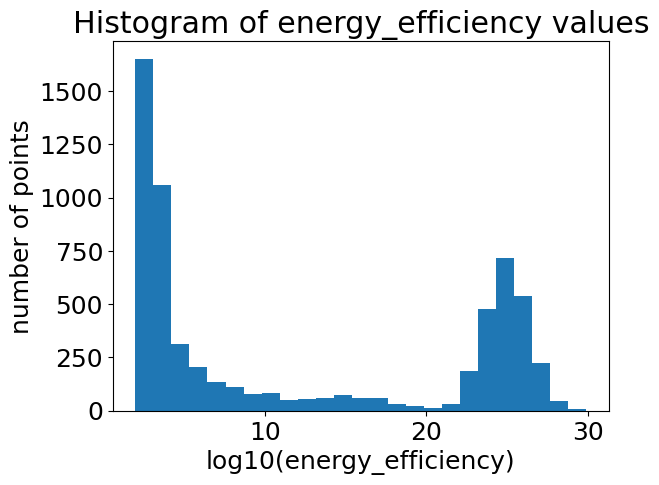

In [5]:

start_points.sort(key=lambda point: point['output'])
outputs = [np.log10(point['output']) for point in start_points if point['output'] < 1e30]
print(f'best energy_efficiency: {start_points[0]["output"]: e} [MJ/kg]')
print(f'{searches}th energy_efficiency: {start_points[searches-1]["output"]: e} [MJ/kg]')
plt.hist(outputs, bins=25)
plt.xlabel('log10(energy_efficiency)')
plt.ylabel('number of points')
plt.title('Histogram of energy_efficiency values')
plt.show()

In [6]:
ranges2 = gd.de.copy(ranges)
for key in ranges:
    if len(ranges[key]) != 2:
        continue
    
    values = [point[key] for point in start_points[:searches]]
    ranges2[key][0] = min(values)
    ranges2[key][1] = max(values)
    print(f'old {key}: {ranges[key][1]-ranges[key][0]: e}')
    print(f'new {key}: {ranges2[key][1]-ranges2[key][0]: e}')

old R_E:  4.500000e-04
new R_E:  3.348318e-04
old mu_L:  5.290000e-02
new mu_L:  1.322848e-02
old c_L:  9.800000e+02
new c_L:  3.356642e+02
old surfactant:  8.045019e-01
new surfactant:  7.790001e-01
old p_A: -4.500000e+05
new p_A:  3.867837e+05
old logf:  1.200000e+00
new logf:  4.367931e-01


In [7]:
ranges2

{'R_E': [0.00016240805696578165, 0.0004972398596735667],
 'ratio': [1.0],
 'gases': [[11, 1]],
 'fractions': [[0.25, 0.75]],
 'P_amb': [5066.25],
 'T_inf': [293.15],
 'alfa_M': [0.35],
 'P_v': [2338.1],
 'mu_L': [0.00025874618045952234, 0.013487225487669974],
 'c_L': [1572.9761784498965, 1908.640422297481],
 'surfactant': [0.24341556904836487, 1.0224157084078604],
 'p_A': [-569450.2332753723, -182666.55451239122],
 'logf': [3.8158367932762465, 4.252629934546848],
 'n': [1.0]}

In [8]:
kwargs_list = [dict(
    ranges=ranges2,
    path=save_path,
    to_optimize=to_optimize,
    start_point=start_point,
    step_limit=100,
    max_step_until_decay=20,
    first_step=0.01,
    min_step=10e-5,
    decay=0.5,
    delta=1e-6,
    verbose=False,
    t_int=[0.0, 1.0],
    LSODA_timeout=50,
    Radau_timeout=500,
    ) for start_point in start_points[:searches]]

# Run gradient_search() multithread

In [9]:
"""Save settings as txt"""

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gd.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
gradient descent general settings:
    to_optimize = '{to_optimize}'   # key in data from de.get_data()
    searches = {searches}    # number os total searches
    trial_points = {trial_points}  # number of trial start_points. best ones will be used for searches

ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list[:searches]:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_descent_settings')

In [10]:
"""Gradient descent, multithread"""

best_output = 1.0e30
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count(), maxtasksperchild=1) as pool:
    results = pool.imap_unordered(gd.search, kwargs_list)
    for result in results:
        last_data, best_outputs, elapsed = result
        num += 1
        to_plot.append(best_outputs)
        last_points.append(last_data)
        if best_outputs[-1] < best_output and best_outputs[-1] > 0:
            best_output = best_outputs[-1]
        
        # print stuff:
        print(f'{num: >3}/{searches}: Total {len(best_outputs): <3} steps, finished in {elapsed: 8.2f} [s]   ({(elapsed / len(best_outputs)): 4.2f} [s/step]).   '+
              f'Final {to_optimize}: {best_outputs[-1]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / searches): .2f} [s/search])')

Folder already exists with 1 csv in it


Folder already exists with 2 csv in it
Folder already exists with 3 csv in it
Folder already exists with 4 csv in it
Folder already exists with 4 csv in it
Folder already exists with 5 csv in it
Folder already exists with 7 csv in itFolder already exists with 7 csv in it

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6542940561645D+00   r2 =  0.4654492343734D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6542940561645D+00   r2 =  0.4654492343734D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6542940561645D+00   r2 =  0.4654492343734D-16
 lso

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5495480758790D+00   r2 =  0.4708234038540D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5495480758790D+00   r2 =  0.4708234038540D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5495480758790D+00   r2 =  0.4708234038540D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5495480758790D+00   r2 =  0.4708234038540D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9132303627984D+00   r2 =  0.5548544227537D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9132303627984D+00   r2 =  0.5548544227537D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9132303627984D+00   r2 =  0.5548544227537D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9132303627984D+00   r2 =  0.5548544227537D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5807093292480D+00   r2 =  0.5294951602155D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5807093292480D+00   r2 =  0.5294951602155D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5807093292480D+00   r2 =  0.5294951602155D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5807093292480D+00   r2 =  0.5294951602155D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042464313417D+00   r2 =  0.5085898024263D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9014304260984D+00   r2 =  0.5078986571220D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9014304260984D+00   r2 =  0.5078986571220D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9014304260984D+00   r2 =  0.5078986571220D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9014304260984D+00   r2 =  0.5078986571220D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  1/16: Total 89  steps, finished in  9740.14 [s]   ( 109.44 [s/step]).   Final energy_efficiency:     94.9 (best:   94.9)
Folder already exists with 9 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5818795798109D+00   r2 =  0.5085927509612D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5818795798109D+00   r2 =  0.5085927509612D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5818795798109D+00   r2 =  0.5085927509612D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6116938300501D+00   r2 =  0.5078944648401D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6116938300501D+00   r2 =  0.5078944648401D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6116938300501D+00   r2 =  0.5078944648401D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6116938300501D+00   r2 =  0.5078944648401D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5968342705194D+00   r2 =  0.5383123864527D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5968342705194D+00   r2 =  0.5383123864527D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5968342705194D+00   r2 =  0.5383123864527D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5968342705194D+00   r2 =  0.5383123864527D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6120976923931D+00   r2 =  0.5382850102707D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6120976923931D+00   r2 =  0.5382850102707D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6120976923931D+00   r2 =  0.5382850102707D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6120976923931D+00   r2 =  0.5382850102707D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8281338753903D+00   r2 =  0.5079269565143D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8281338753903D+00   r2 =  0.5079269565143D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8281338753903D+00   r2 =  0.5079269565143D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8281338753903D+00   r2 =  0.5079269565143D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8590872638428D+00   r2 =  0.5079134948295D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8590872638428D+00   r2 =  0.5079134948295D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8590872638428D+00   r2 =  0.5079134948295D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8590872638428D+00   r2 =  0.5079134948295D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  2/16: Total 98  steps, finished in  10556.81 [s]   ( 107.72 [s/step]).   Final energy_efficiency:     96.1 (best:   94.9)
Folder already exists with 10 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028746895812D+00   r2 =  0.5383906793344D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028746895812D+00   r2 =  0.5383906793344D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6028746895812D+00   r2 =  0.5383906793344D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  3/16: Total 61  steps, finished in  10719.37 [s]   ( 175.73 [s/step]).   Final energy_efficiency:     81.3 (best:   81.3)
Folder already exists with 11 csv in it
  4/16: Total 100 steps, finished in  11460.19 [s]   ( 114.60 [s/step]).   Final energy_efficiency:     89.5 (best:   81.3)
Folder already exists with 12 csv in it
  5/16: Total 95  steps, finished in  11519.32 [s]   ( 121.26 [s/step]).   Final energy_efficiency:     88.3 (best:   81.3)
Folder already exists with 13 csv in it
  6/16: Total 100 steps, finished in  12083.35 [s]   ( 120.83 [s/step]).   Final energy_efficiency:     87.9 (best:   81.3)
Folder already exists with 14 csv in it
  7/16: Total 99  steps, finished in  12487.21 [s]   ( 126.13 [s/step]).   Final energy_efficiency:     98.1 (best:   81.3)
Folder already exists with 15 csv in it
  8/16: Total 100 steps, finished in  15305.14 [s]   ( 153.05 [s/step]).   Final energy_efficiency:     88.6 (best:   81.3)
Folder already exists with 16 csv in it
  9/16: Total 90

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 10/16: Total 100 steps, finished in  6979.99 [s]   ( 69.80 [s/step]).   Final energy_efficiency:    102.3 (best:   81.3)


KeyboardInterrupt: 

## Plot results

In [12]:
[(len(x), x[-1]) for x in to_plot if x[-1]<60]

[(15, 56.28834404952193),
 (18, 58.30416986700402),
 (31, 59.84239220765513),
 (31, 58.943008555268065),
 (17, 59.642758305883866),
 (56, 59.16471291701118),
 (25, 59.58318781111264),
 (25, 59.566349838508046)]

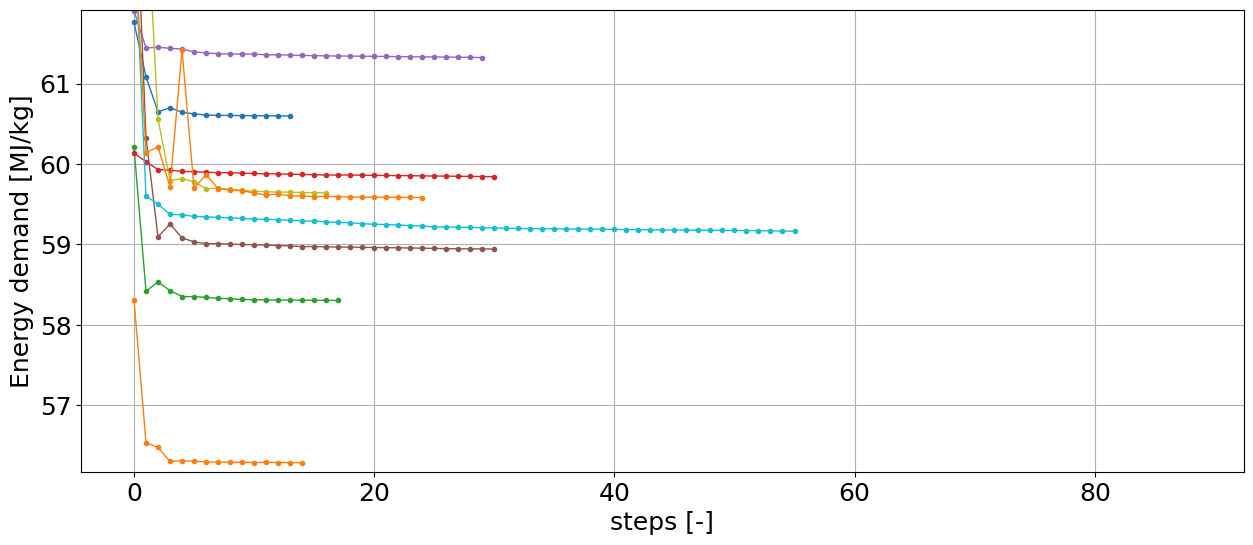

In [16]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[:20]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
#fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'Energy demand [MJ/kg]')
ax.set_ylim(0.998*best_output, 1.1*best_output)
#ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()
fig.savefig('images/convergence.png', bbox_inches='tight')

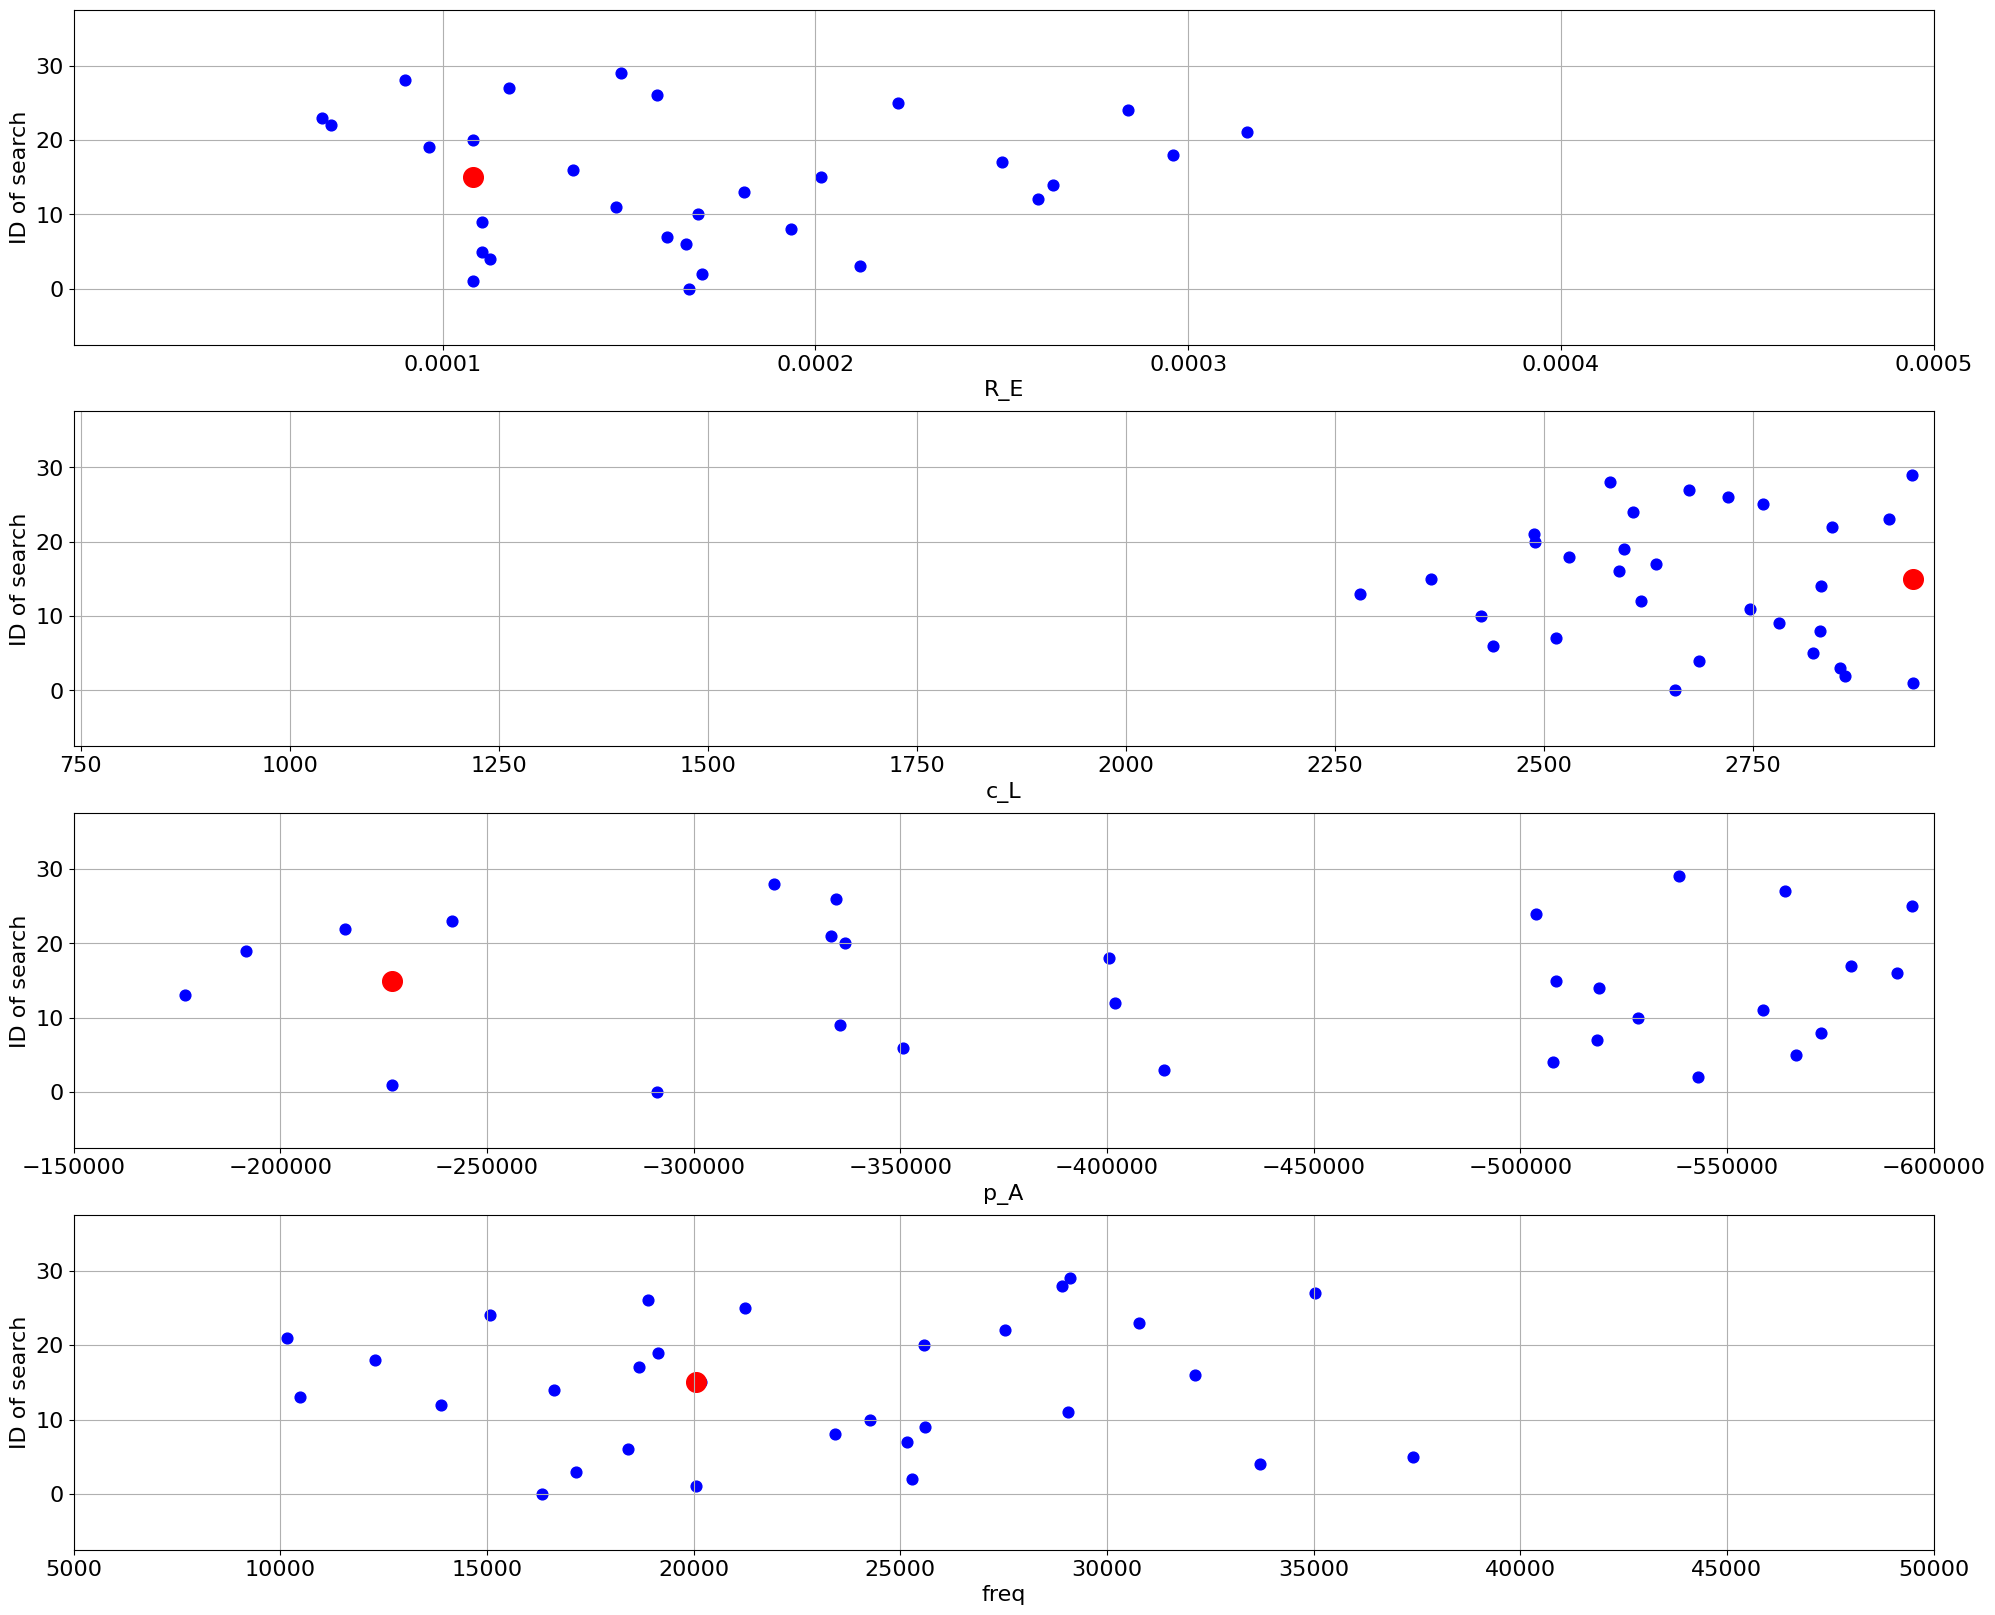

In [17]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.25*n, 1.25*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
